In [73]:
import glam
import pandas as pd
import numpy as np
import os.path
from statsmodels.stats.outliers_influence import summary_table


In [2]:
import matplotlib.pyplot as plt

from scipy.stats import invgauss
import seaborn as sns
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
from scipy import stats
from scipy.stats.stats import pearsonr # Pearson's correlation
import statsmodels.api as sm

#import warnings
#warnings.filterwarnings('ignore')

In [3]:
np.random.seed(23) # from random.org

In [4]:
# For rpy2

import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [5]:
# For MacMini proper running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [7]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [8]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)

## Custom functions

In [9]:
def balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats):
    
    mean_rts_trials = np.zeros((value_tests.shape[0])) * np.nan
    choice_trials = np.zeros((value_tests.shape[0])) * np.nan
    DEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    AbsDEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    Ev_drifts_0_trials  = []
    Ev_drifts_1_trials = []

    n_trials, n_items = value_tests.shape

    running_idx_value = 0
    #we iterate for all the combinations of trials + gaze
    for trial in range(n_trials):
        
            # intialize the drifts
            evidence_drifts_0 = []
            evidence_drifts_1 = []

            #define value and gaze values for this particular trial
            value_trial =value_tests[trial]
            gaze_trial =gaze_tests[trial]
            
            Sim_value = value_trial
            Sim_gaze = gaze_trial
            
            Delta_E = np.zeros(n_repeats) * np.nan            
            AbsDelta_E = np.zeros(n_repeats) * np.nan
            rts = np.zeros(n_repeats) * np.nan
            choices = np.zeros(n_repeats) * np.nan
            trial_idx = np.zeros(n_repeats) * np.nan
            repeat_idx = np.zeros(n_repeats) * np.nan
            running_idx = 0
        
            for repeat in range(n_repeats):
                    

                    
                    Evi_0, Evi_1, choice, rt = glam.driftSim.simulate_trial_drift(parameters, value_trial, gaze_trial,
                                                boundary=boundary,
                                                error_weight=error_weight,
                                                error_range=error_range)
                    
                    Delta_E[running_idx] = Evi_1[-1] - Evi_0[-1]
                    AbsDelta_E[running_idx] = abs(Evi_0[-1] - Evi_1[-1])                        
                    rts[running_idx] = rt
                    choices[running_idx] = choice
                    trial_idx[running_idx] = trial
                    repeat_idx[running_idx] = repeat
                    # Add a new sequence of drift for this particular trial
                    evidence_drifts_0.append(Evi_0)
                    evidence_drifts_1.append(Evi_1)
                    
                    running_idx += 1
                    
               
            # Add the mean value for this parameters interation               
            mean_rts_trials [running_idx_value] = rts.mean()
            choice_trials [running_idx_value]= choices.mean() 
            DEv_trials [running_idx_value] = Delta_E.mean()
            AbsDEv_trials [running_idx_value]= AbsDelta_E.mean()
            Ev_drifts_0_trials.append(evidence_drifts_0)
            Ev_drifts_1_trials.append(evidence_drifts_1)
 
            running_idx_value += 1 

    return AbsDEv_trials,mean_rts_trials,Ev_drifts_0_trials,Ev_drifts_1_trials,choice_trials

In [10]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

    
        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [11]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [12]:
def add_difficulty(df):
    """
    Compute trial difficulties and add to DataFrame.

    Maximum value -  other values.
    In the binary case, this reduces to abs(v0 - v1).

    Parameters
    ----------
    df :      <pandas DataFrame>
              Trial wise DataFrame containing columns for item_value_i
    """

    values = df[['LVal','RVal']].values
    values_sorted = np.sort(values, axis=1)
    difficulty = values_sorted[:, -1] - np.mean(values_sorted[:, :-1], axis=1)

    levels =  (np.max(difficulty) - np.min(difficulty))/10

    lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 
    
    difficulty2= []
    for i in range(len(difficulty)):
         difficulty2.append( lev_label[ int(difficulty[i]//levels)] )
     
    difficulty = difficulty2
    
    df['difficulty'] = np.around(difficulty, decimals = 0)
    df['difficulty'] = difficulty
    
    return df.copy()

In [13]:
def plot_DEv_Conf(data, ax=None, xlims=(0, 10), xlabel_skip=2,color1 = '#4F6A9A'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 15))
        # Set seaborn style for the plot
        sns.set(style='white')

    df = data.copy()

    # Compute relevant variables
    df = add_difficulty(df)
    
    
    # select data to use
    
    data_labels = ['zConf_human','zAbsDEv']
    
    for i in range(len(data_labels)):
        # Compute summary statistics
        subject_means = df.groupby(['Part', 'difficulty'])[data_labels[i]].mean()
        means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
        sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]
    
        x = np.arange(len(means))
        
        # Add labels for scatter plot of mean rt per participant
        scatter_data = subject_means.reset_index()
        x_scatter = []
        group_labels = np.sort(scatter_data.difficulty.unique())
        for ii in range(len(scatter_data.difficulty.values)):
            a = scatter_data.difficulty.values[ii]
            position_item =  x[np.where(group_labels==a)[0][0]]
            x_scatter.append(position_item) 
        ## ********    
        
        predicted = False if i == 0 else True
        
        # Colors for predicted
        c_pred = [color1,'#606060','#607681' ]
        
        if not predicted:  # plot underlying data
            ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
                    color=color1, linewidth=1)
            ax.vlines(x, means - sems, means + sems,
                      linewidth=1, color= color1)
            jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
            ax.plot(x_scatter+jittr, scatter_data[data_labels[i]].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
        else:  # plot predictions
            ax.plot(x, means, '--o', markerfacecolor=c_pred[i],color=c_pred[i], linewidth=2.5, markersize = 10)

    #ax.set_ylim(2000, 3500)
    ax.set_xlabel('|ΔVal|')
    ax.set_ylabel( r'zΔ$\epsilon$ / zConfidence')
    ax.set_xticks(x[::xlabel_skip])
    ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))



In [14]:
def add_difficulty_TotVal(df):
    """
    Compute trial difficulties and add to DataFrame.

    Maximum value -  other values.
    In the binary case, this reduces to abs(v0 - v1).

    Parameters
    ----------
    df :      <pandas DataFrame>
              Trial wise DataFrame containing columns for item_value_i
    """

    difficulty = df[['TotVal']].values

    levels =  (np.max(difficulty) - np.min(difficulty))/10

    lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 
    
    difficulty2= []
    for i in range(len(difficulty)):
         difficulty2.append( lev_label[ int(difficulty[i]//levels)] )
     
    difficulty = difficulty2
    
    df['difficulty'] = np.around(difficulty, decimals = 0)
    df['difficulty'] = difficulty
    
    return df.copy()

In [15]:
def plot_DEv_Conf_TotVal(data, ax=None, xlims=(0, 10), xlabel_skip=2,color1 = '#4F6A9A'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 15))
        # Set seaborn style for the plot
        sns.set(style='white')

    df = data.copy()

    # Compute relevant variables
    df = add_difficulty_TotVal(df)
    print ('Done with TotVal')
    
    # select data to use
    
    data_labels = ['zConf_human','zAbsDEv']
    
    for i in range(len(data_labels)):
        # Compute summary statistics
        subject_means = df.groupby(['Part','difficulty'])[data_labels[i]].mean()
        means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
        sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]
    
        x = np.arange(len(means))
        
        # Add labels for scatter plot of mean rt per participant
        scatter_data = subject_means.reset_index()
        x_scatter = []
        group_labels = np.sort(scatter_data.difficulty.unique())
        for ii in range(len(scatter_data.difficulty.values)):
            a = scatter_data.difficulty.values[ii]
            position_item =  x[np.where(group_labels==a)[0][0]]
            x_scatter.append(position_item) 
        ## ********    
        
        predicted = False if i == 0 else True
        
        # Colors for predicted
        c_pred = [color1,'#606060','#607681' ]
        
        if not predicted:  # plot underlying data
            ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
                    color=color1, linewidth=1)
            ax.vlines(x, means - sems, means + sems,
                      linewidth=1, color= color1)
            jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
            ax.plot(x_scatter+jittr, scatter_data[data_labels[i]].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
        else:  # plot predictions
            ax.plot(x, means, '--o', markerfacecolor=c_pred[i],color=c_pred[i], linewidth=2.5, markersize = 10)

    #ax.set_ylim(2000, 3500)
    ax.set_xlabel('|ΣVal|')
    ax.set_ylabel( r'zΔ$\epsilon$ / zConfidence')
    ax.set_xticks(x[::xlabel_skip])
    ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))



## Define some parameters for the simulations


In [16]:
# Parameters for the simulations
boundary=1
error_weight=0.05

## Load data and GLAM structure (Like & Dislike)
Used binned data for simulation.

In [17]:
data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Like_NoBin_31.csv'))
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

data2 = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Dislike_NoBin_Inv_31.csv'))
# Subset only necessary columns
data2 = data2[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

In [18]:
# Load data for FF2018 study 

# Like condition 

data_all0 = pd.read_csv('data/FF2018_data/DataFoodFramingNotebook_31.csv')
data_all0 = data_all0.drop(['Unnamed: 0'], axis=1)
data_all = data_all0.loc[data_all0['BlockCond'] == 1] # 1 = Like, 2 = Dislike

data_all=data_all.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

# Dislike condition

data_all2 = data_all0.loc[data_all0['BlockCond'] == 2] # 1 = Like, 2 = Dislike

data_all2=data_all2.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

---------------------------------------------------------
# Like condition


## Load parameter estimates for participants


Use the parameter estimates from GLAM fit for Like, Binned data

In [19]:
sufix = '_Like_NoBin_NUTS_31'
glam_full = glam.GLAM(data)
glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))
glam_full.estimates = pd.DataFrame.from_dict(glam_full.estimates.item(0))
params_part = glam_full.estimates

In [20]:
params_part

,v_sd,v_mu,gamma_mu,tau_mu,t0,b,tau_sd,SNR,p_error,tau,gamma_sd,gamma,SNR_sd,v,s,SNR_mu
0,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,151.23,0.05,3.74,0.38,-0.11,35.54,0.000047,0.007843,164.29
1,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,137.71,0.05,4.30,0.38,0.29,35.54,0.000072,0.010344,164.29
2,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,141.48,0.05,2.59,0.38,-0.00,35.54,0.000058,0.008574,164.29
3,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,157.60,0.05,4.65,0.38,-0.10,35.54,0.000043,0.007178,164.29
4,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,96.58,0.05,4.22,0.38,-0.37,35.54,0.000080,0.007063,164.29
5,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,113.65,0.05,2.80,0.38,0.15,35.54,0.000059,0.008615,164.29
6,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,163.65,0.05,3.55,0.38,-0.00,35.54,0.000069,0.010656,164.29
7,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,150.49,0.05,3.29,0.38,-0.08,35.54,0.000045,0.007405,164.29
8,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,175.26,0.05,1.24,0.38,-0.71,35.54,0.000053,0.009622,164.29
9,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,137.66,0.05,4.77,0.38,-0.08,35.54,0.000048,0.007104,164.29


# Run drift simulations for selected values and parameters

#  1. Including gaze information in the simulation 

In [21]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_like_31_part.csv')):  
        data_simulation = pd.read_csv("results/simulations_evidence/DEvidence_simulations_like_31_part.csv")

In [22]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 0 # We DO want to use the gaze from the particpants

In [23]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_like_31_part.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    part_id = data_all['Part'].unique()
    
    for i in (data['subject'].unique()):    
        for k in range(0,repeat_extra) :
            PartData = data.loc[data['subject'] == i] # dataframe including participant GLAM data
            PartDataAll = data_all.loc[data_all['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
            
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])
                
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))
        
    data_simulation =  pd.DataFrame()
    data_simulation["Part"] = Part_number
    data_simulation["LVal"] = LVal
    data_simulation["RVal"] = RVal
    data_simulation["LGaze"] = LGaze
    data_simulation["RGaze"] = RGaze
    data_simulation["AbsDVal"] = absDVal
    data_simulation["TotVal"] = TotVal
    data_simulation["AbsDEv"] = AbsDEvid
    data_simulation["RTsim"] = RT_sim
    data_simulation["Correct_sim"] = Correct_sim
    data_simulation["Choice_sim"] = Choice_sim
    data_simulation["Conf_human"] = Conf_human
    data_simulation["zConf_human"] = zConf_human
    
    data_simulation["zLVal"] = z_score1(data_simulation,'Part',"LVal")
    data_simulation["zRVal"] = z_score1(data_simulation,'Part',"RVal")
    data_simulation["zAbsDVal"] = z_score1(data_simulation,'Part',"AbsDVal")
    data_simulation["zTotVal"] = z_score1(data_simulation,'Part',"TotVal")
    data_simulation["zAbsDEv"] = z_score1(data_simulation,'Part',"AbsDEv")
    data_simulation["zRTsim"] = z_score1(data_simulation,'Part',"RTsim")

In [24]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_like_31_part.csv')):   
        data_simulation.to_csv("results/simulations_evidence/DEvidence_simulations_like_31_part.csv")

In [25]:
data_simulation

,Unnamed: 0,Part,LVal,RVal,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,0,1.10,0.95,0.15,2.05,0.562037,3114.0,1,0.0,80,0.582155,-0.898735,-1.237881,-0.988498,-1.497033,-0.587035,0.502240
1,1,0,2.00,1.70,0.30,3.70,0.240365,3815.0,1,0.0,78,0.432565,1.136137,0.457846,-0.570823,1.116834,-1.413819,1.168099
2,2,0,1.10,2.30,1.20,3.40,0.560002,1744.0,1,1.0,82,0.731746,-0.898735,1.814428,1.935228,0.641585,-0.592267,-0.799083
3,3,0,1.25,1.40,0.15,2.65,1.045098,2105.0,1,1.0,42,-2.260059,-0.559590,-0.220445,-0.988498,-0.546536,0.654559,-0.456179
4,4,0,2.00,2.30,0.30,4.30,0.218963,2945.0,1,1.0,70,-0.165796,1.136137,1.814428,-0.570823,2.067331,-1.468827,0.341712
5,5,0,1.70,1.85,0.15,3.55,0.893705,1781.0,1,1.0,74,0.133385,0.457846,0.796992,-0.988498,0.879210,0.265440,-0.763937
6,6,0,1.85,0.65,1.20,2.50,1.199453,3104.0,1,0.0,70,-0.165796,0.796992,-1.916172,1.935228,-0.784160,1.051293,0.492741
7,7,0,1.55,0.80,0.75,2.35,1.337536,1539.0,1,0.0,76,0.282975,0.118701,-1.577026,0.682203,-1.021784,1.406204,-0.993806
8,8,0,1.55,1.10,0.45,2.65,1.010269,1981.0,1,0.0,90,1.330107,0.118701,-0.898735,-0.153148,-0.546536,0.565040,-0.573963
9,9,0,1.10,2.00,0.90,3.10,0.254428,3251.0,1,1.0,54,-1.362518,-0.898735,1.136137,1.099878,0.166337,-1.377672,0.632372


Pearson's r = 0.08 p =  0.0


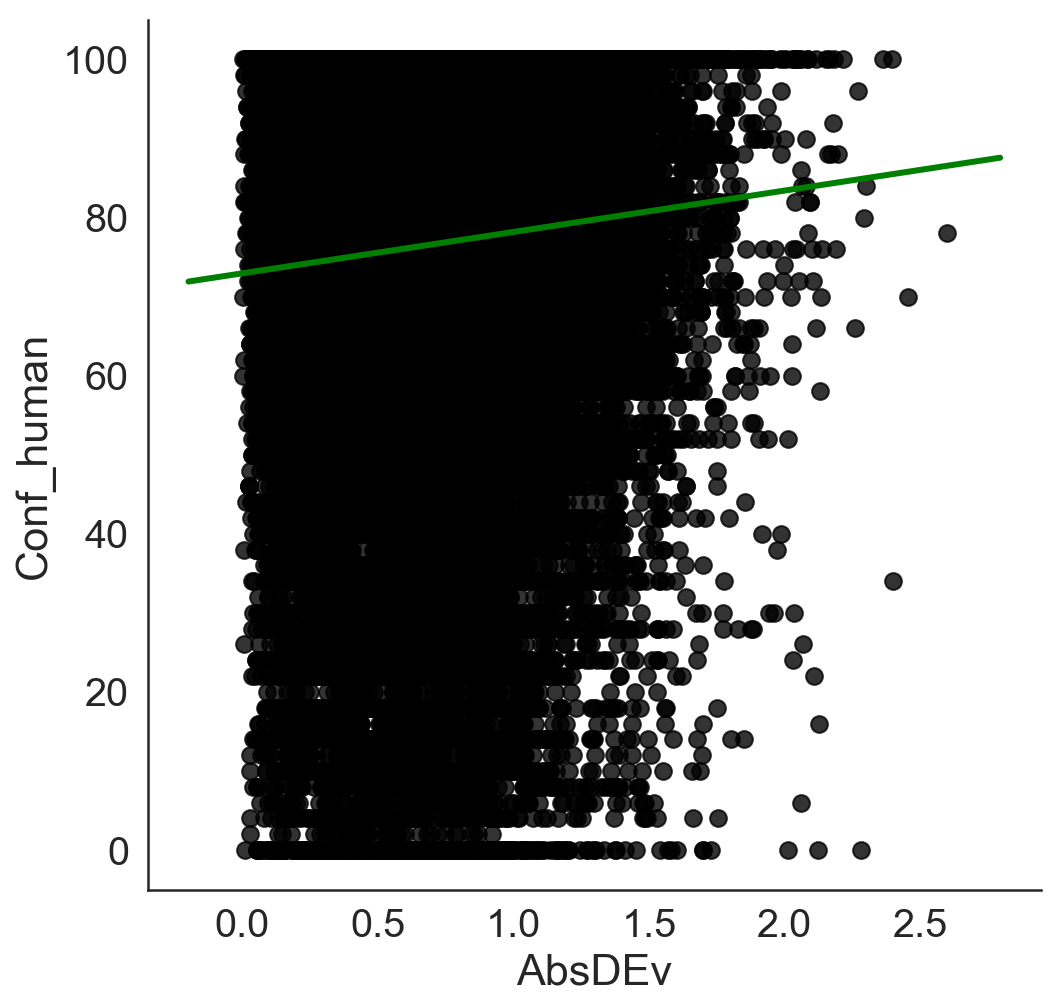

Pearson's r = 0.083 p =  0.0


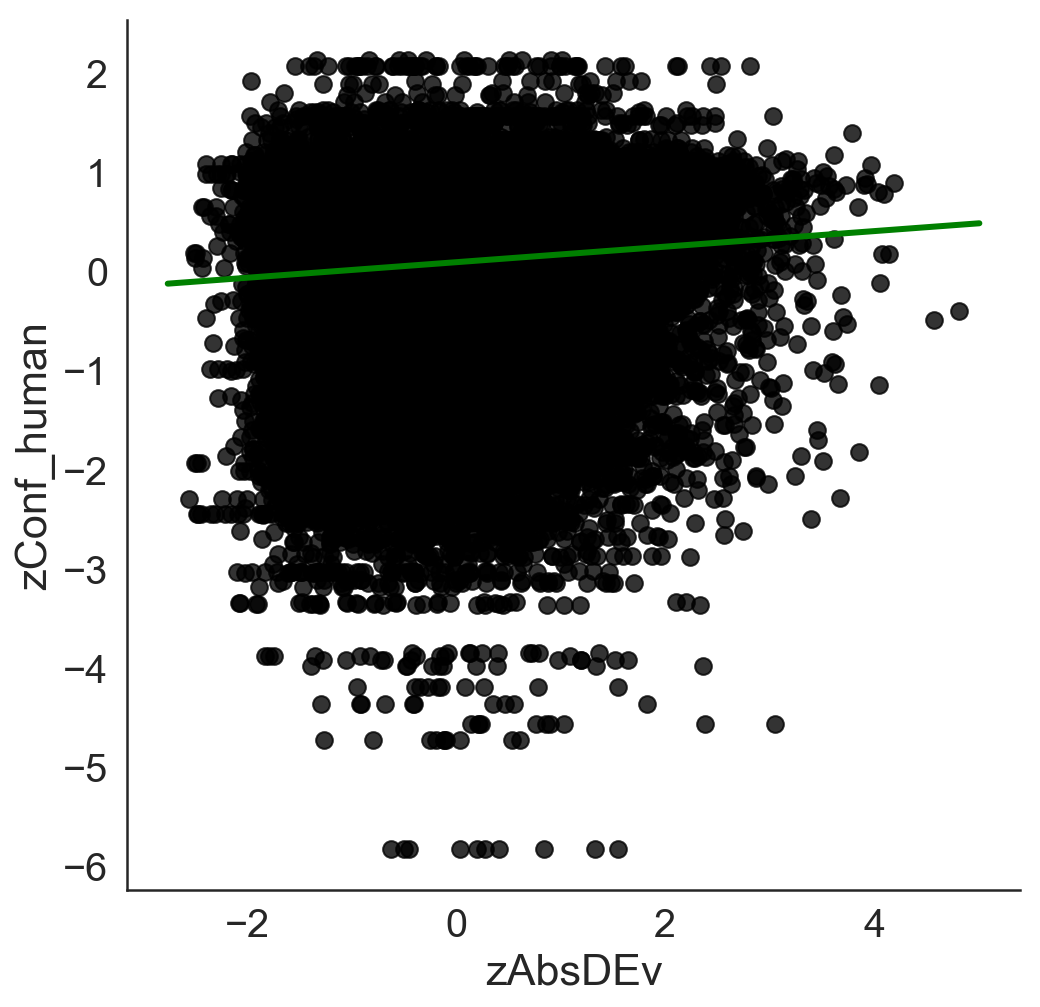

In [26]:
correl_plot(data_simulation,'AbsDEv', "AbsDEv",'Conf_human','Conf_human')
correl_plot(data_simulation,'zAbsDEv', "zAbsDEv",'zConf_human','zConf_human')

In [27]:
%%R -i data_simulation
d <- data_simulation

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 102100.6
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal + zRTsim, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal       zRTsim  
 -1.183e-15    1.604e-01    7.826e-02   -2.024e-01  

Degrees of Freedom: 37199 Total (i.e. Null);  37196 Residual
Null Deviance:	    37200 
Residual Deviance: 33840 	AIC: 102100


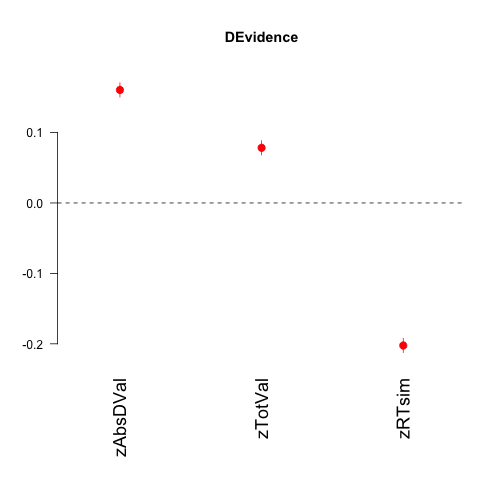

In [28]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

# We calculate the original regression with human data

In [122]:
%%R -i data_all
d <- data_all

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 9752.417
Call:  glm(formula = zConf ~ zAbsDVal + zTotVal + zRT, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal          zRT  
    0.07449      0.14002      0.08652     -0.26744  

Degrees of Freedom: 3719 Total (i.e. Null);  3716 Residual
Null Deviance:	    3353 
Residual Deviance: 2964 	AIC: 9721


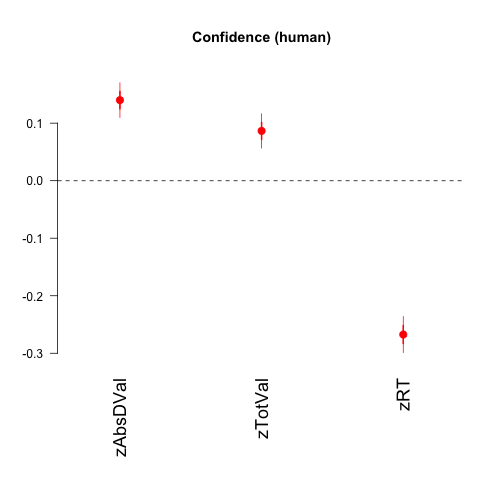

In [123]:
%%R    
title_plot = "Confidence (human)"
ModelChoice_1 <- glm(zConf ~ zAbsDVal + zTotVal + zRT  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

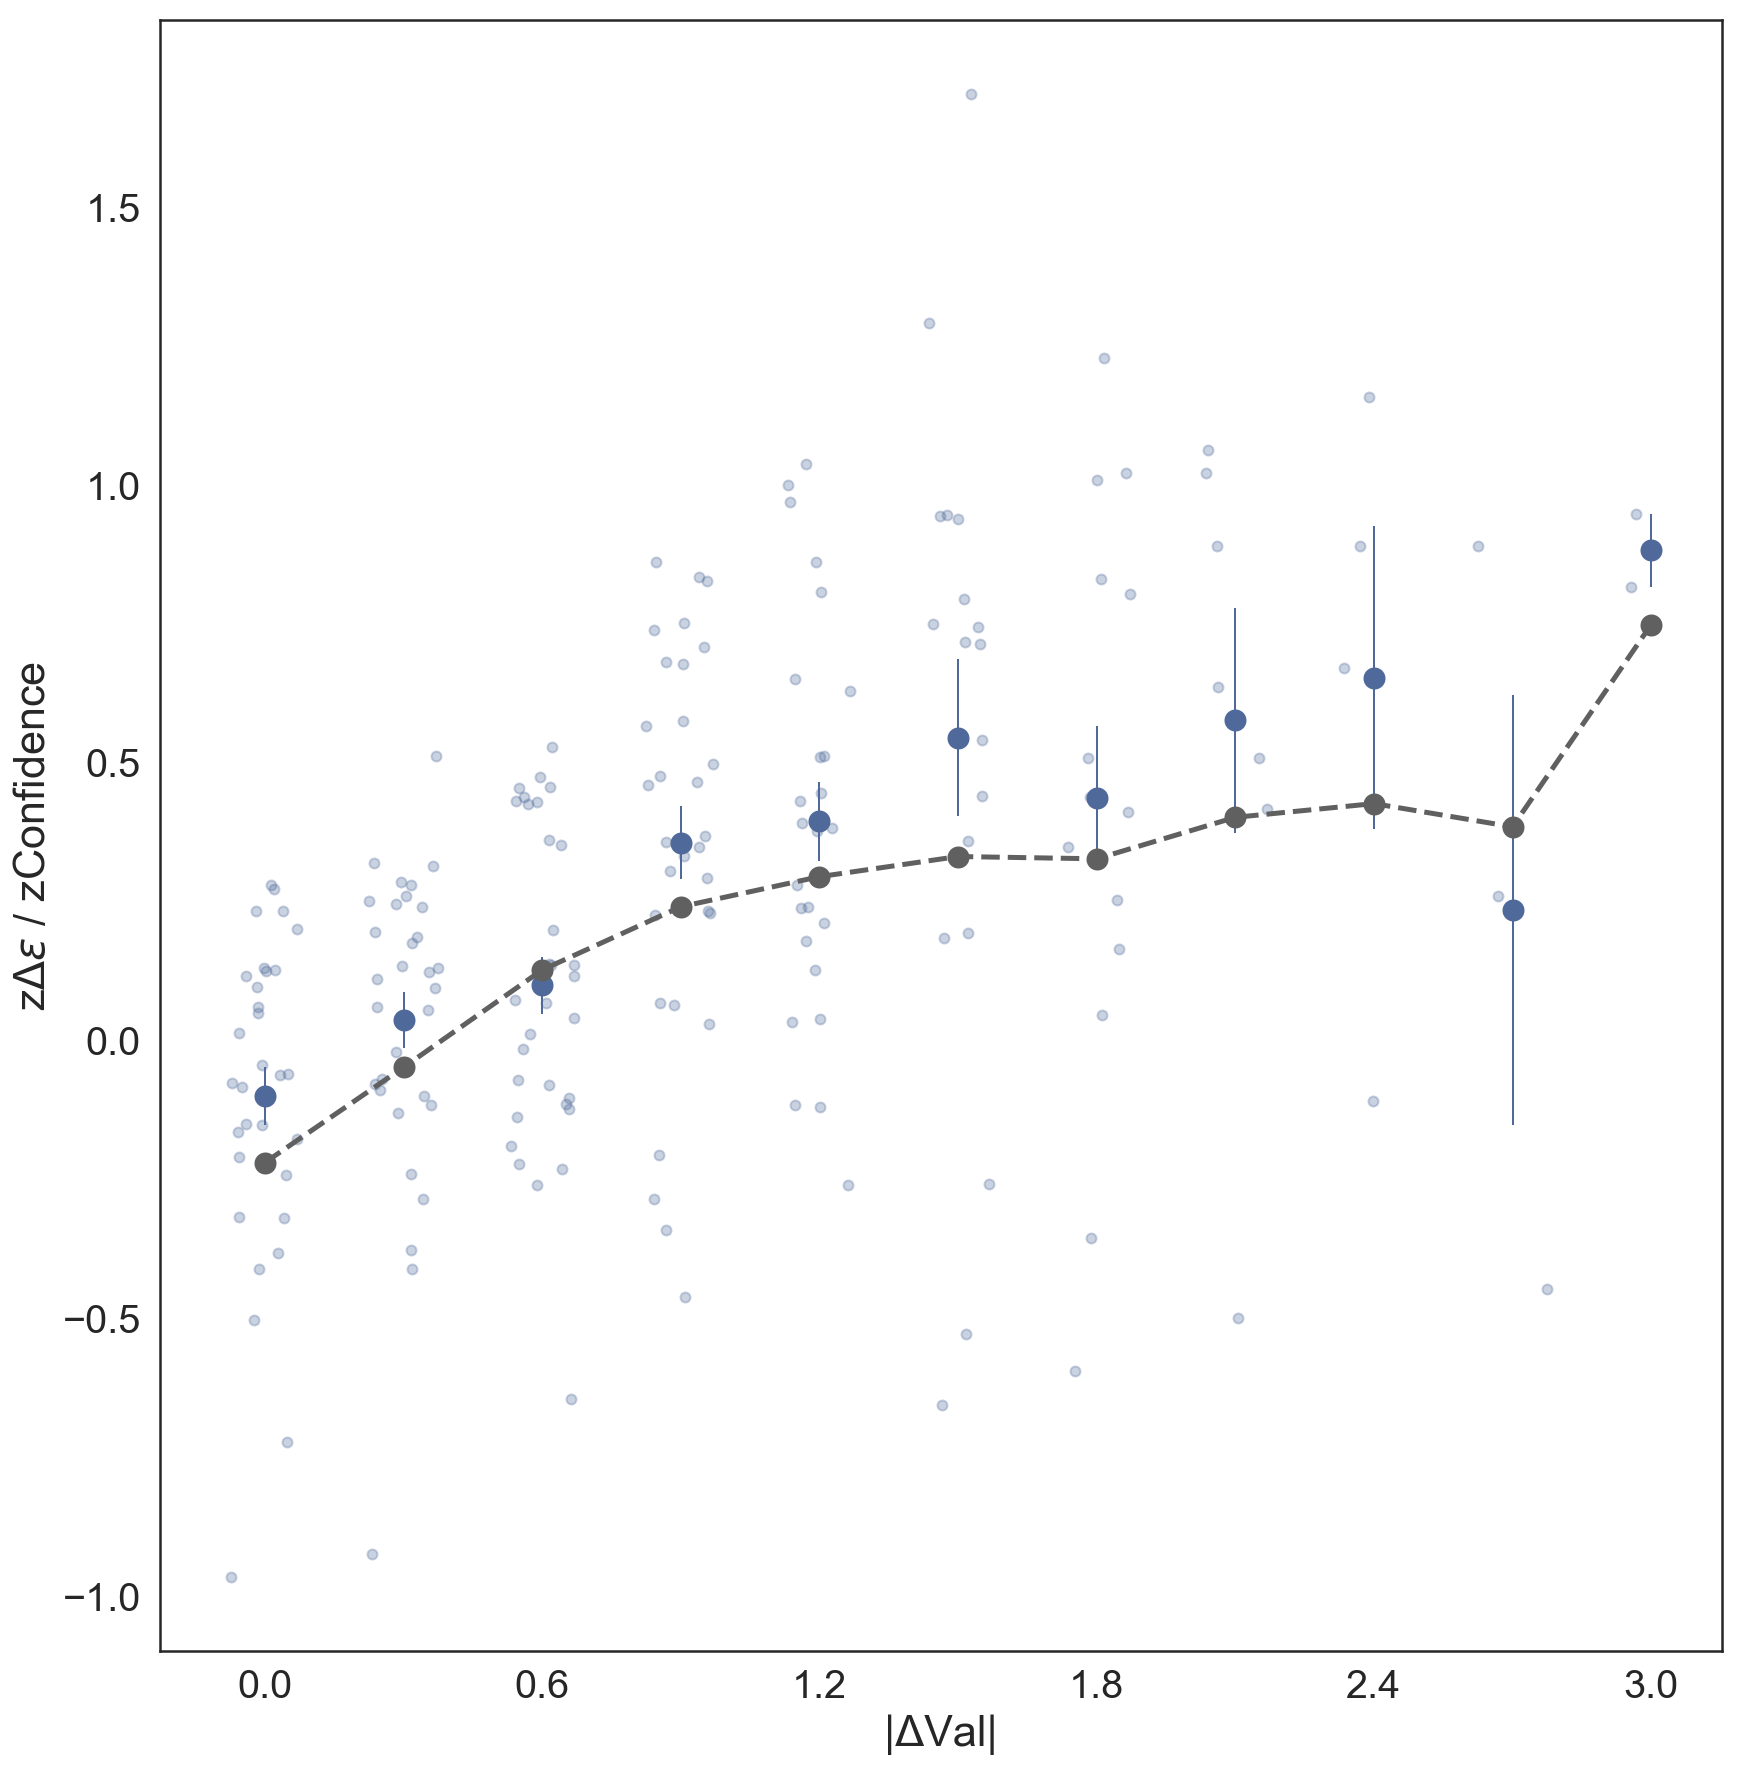

In [29]:
plot_DEv_Conf(data_simulation, xlabel_skip=2,color1 = '#4F6A9A')

Done with TotVal


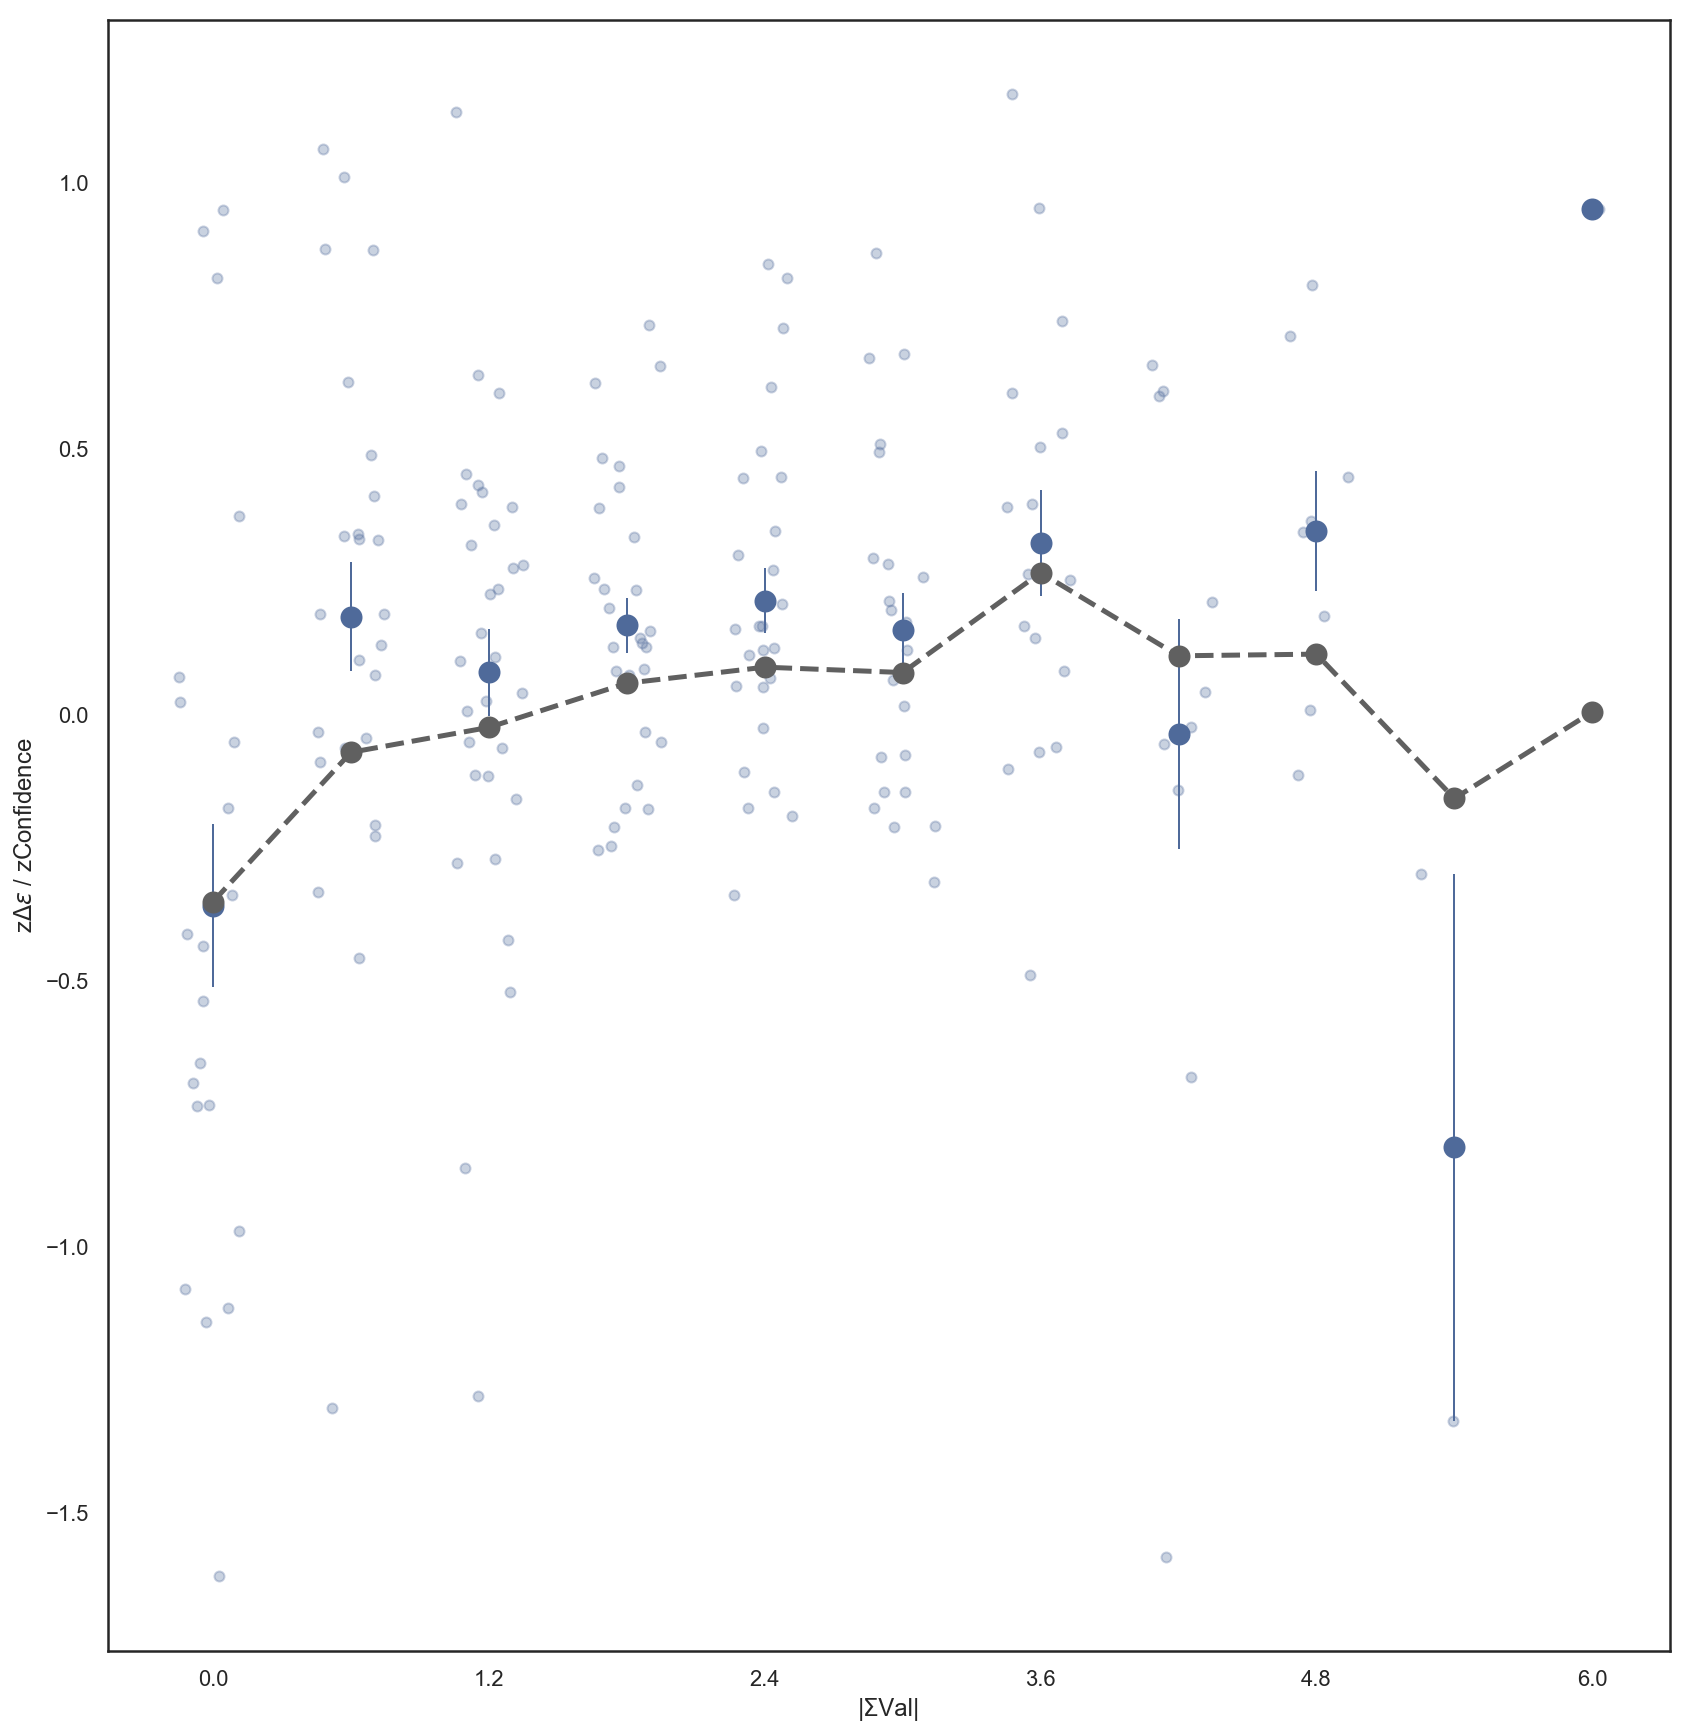

In [30]:
plot_DEv_Conf_TotVal(data_simulation, xlabel_skip=2,color1 = '#4F6A9A')

#  2. Excluding gaze information in the simulation 

In [31]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_like_31_part.csv')):  
        data_simulation2 = pd.read_csv("results/simulations_evidence/DEvidence_simulations_NoGaze_like_31_part.csv")

In [32]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 1 # We DON'T want to use the gaze from the particpants

In [33]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_like_31_part.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    part_id = data_all['Part'].unique()
    
    for i in (data['subject'].unique()):    
        for k in range(0,repeat_extra) :
            PartData = data.loc[data['subject'] == i] # dataframe including participant GLAM data
            PartDataAll = data_all.loc[data_all['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])
                
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))

    data_simulation2 =  pd.DataFrame()
    
    data_simulation2["Part"] = Part_number
    data_simulation2["LVal"] = LVal
    data_simulation2["RVal"] = RVal
    data_simulation2["LGaze"] = LGaze
    data_simulation2["RGaze"] = RGaze
    data_simulation2["AbsDVal"] = absDVal
    data_simulation2["TotVal"] = TotVal
    data_simulation2["AbsDEv"] = AbsDEvid
    data_simulation2["RTsim"] = RT_sim
    data_simulation2["Correct_sim"] = Correct_sim
    data_simulation2["Choice_sim"] = Choice_sim
    data_simulation2["Conf_human"] = Conf_human
    data_simulation2["zConf_human"] = zConf_human
    
    data_simulation2["zLVal"] = z_score1(data_simulation2,'Part',"LVal")
    data_simulation2["zRVal"] = z_score1(data_simulation2,'Part',"RVal")
    data_simulation2["zAbsDVal"] = z_score1(data_simulation2,'Part',"AbsDVal")
    data_simulation2["zTotVal"] = z_score1(data_simulation2,'Part',"TotVal")
    data_simulation2["zAbsDEv"] = z_score1(data_simulation2,'Part',"AbsDEv")
    data_simulation2["zRTsim"] = z_score1(data_simulation2,'Part',"RTsim")

subj 0
subj 1
subj 2
subj 3
subj 4
subj 5
subj 6
subj 7
subj 8
subj 9
subj 10
subj 11
subj 12
subj 13
subj 14
subj 15
subj 16
subj 17
subj 18
subj 19
subj 20
subj 21
subj 22
subj 23
subj 24
subj 25
subj 26
subj 27
subj 28
subj 29
subj 30


In [34]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_like_31_part.csv')):   
        data_simulation2.to_csv("results/simulations_evidence/DEvidence_simulations_NoGaze_like_31_part.csv")

In [35]:
data_simulation2

,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,1.10,0.95,0.5,0.5,0.15,2.05,1.563478,3618.0,0,1.0,80,0.582155,-0.898735,-1.237881,-0.988498,-1.497033,2.698379,0.669301
1,0,2.00,1.70,0.5,0.5,0.30,3.70,0.547966,3436.0,1,0.0,78,0.432565,1.136137,0.457846,-0.570823,1.116834,-0.318219,0.508860
2,0,1.10,2.30,0.5,0.5,1.20,3.40,1.189773,2777.0,1,1.0,82,0.731746,-0.898735,1.814428,1.935228,0.641585,1.588283,-0.072079
3,0,1.25,1.40,0.5,0.5,0.15,2.65,0.354577,4233.0,0,0.0,42,-2.260059,-0.559590,-0.220445,-0.988498,-0.546536,-0.892685,1.211452
4,0,2.00,2.30,0.5,0.5,0.30,4.30,0.244040,4878.0,1,1.0,70,-0.165796,1.136137,1.814428,-0.570823,2.067331,-1.221038,1.780050
5,0,1.70,1.85,0.5,0.5,0.15,3.55,1.100297,2316.0,1,1.0,74,0.133385,0.457846,0.796992,-0.988498,0.879210,1.322492,-0.478472
6,0,1.85,0.65,0.5,0.5,1.20,2.50,1.166063,1843.0,1,0.0,70,-0.165796,0.796992,-1.916172,1.935228,-0.784160,1.517850,-0.895443
7,0,1.55,0.80,0.5,0.5,0.75,2.35,1.140236,3010.0,1,0.0,76,0.282975,0.118701,-1.577026,0.682203,-1.021784,1.441132,0.133321
8,0,1.55,1.10,0.5,0.5,0.45,2.65,0.659459,2344.0,1,0.0,90,1.330107,0.118701,-0.898735,-0.153148,-0.546536,0.012973,-0.453788
9,0,1.10,2.00,0.5,0.5,0.90,3.10,0.735075,3552.0,1,1.0,54,-1.362518,-0.898735,1.136137,1.099878,0.166337,0.237592,0.611119


Pearson's r = 0.071 p =  0.0


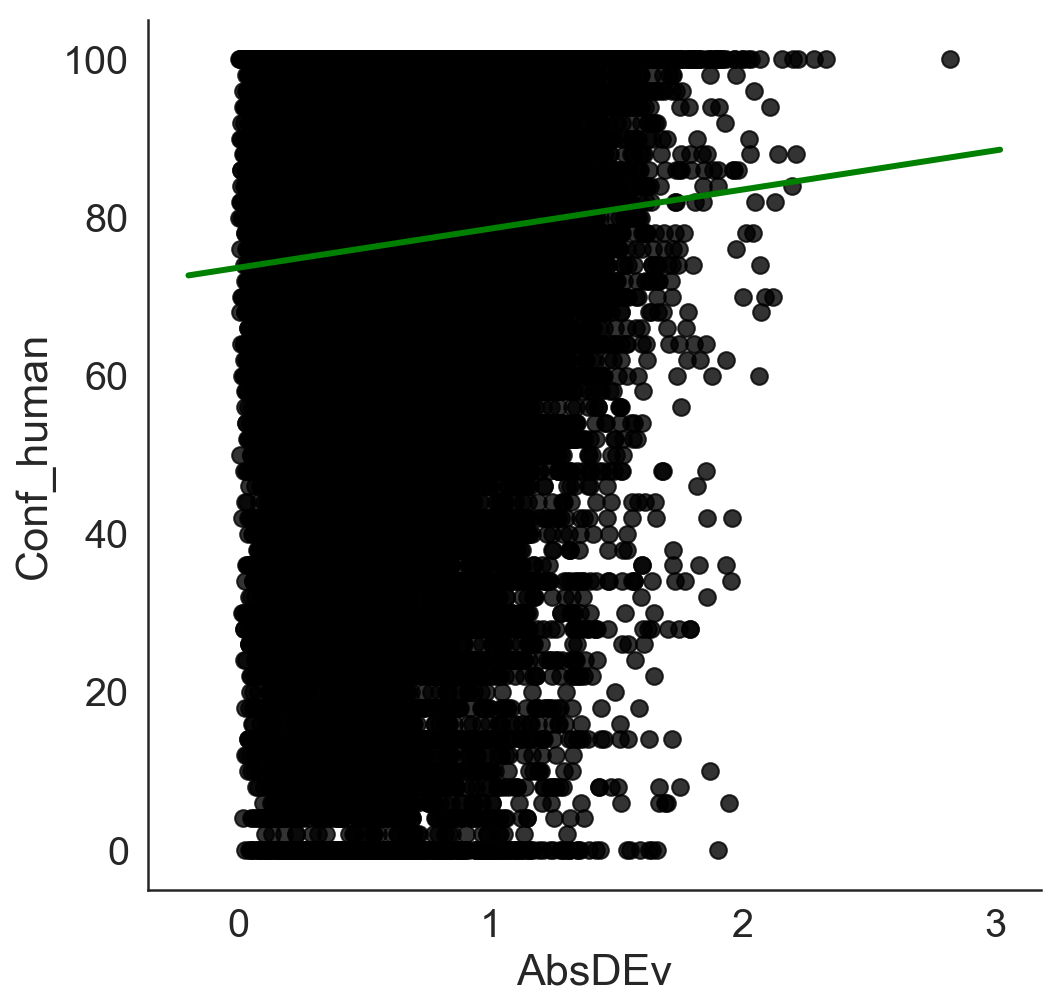

Pearson's r = 0.068 p =  0.0


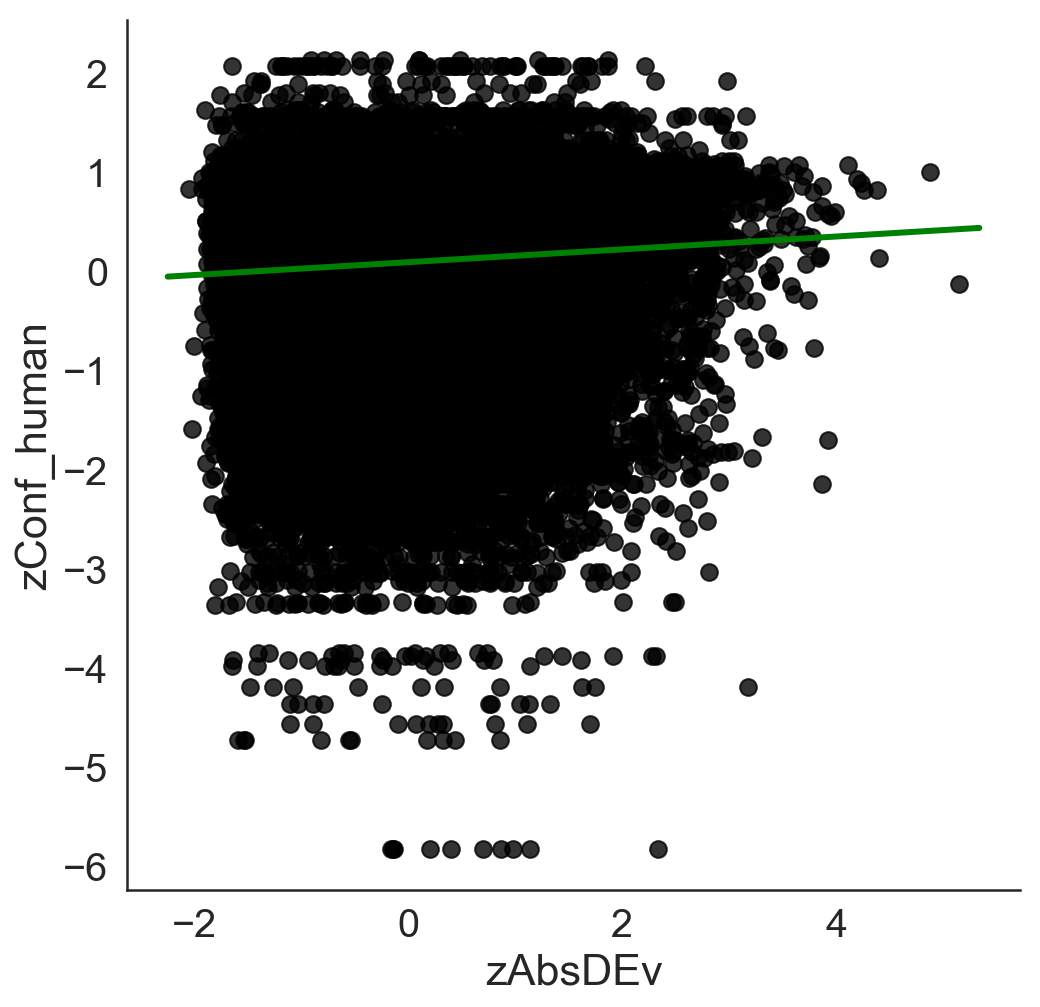

In [36]:
correl_plot(data_simulation2,'AbsDEv', "AbsDEv",'Conf_human','Conf_human')
correl_plot(data_simulation2,'zAbsDEv', "zAbsDEv",'zConf_human','zConf_human')

In [37]:
%%R -i data_simulation2
d <- data_simulation2

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 101669.9
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal + zRTsim, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal       zRTsim  
 -2.618e-16    2.390e-01    4.253e-03   -1.715e-01  

Degrees of Freedom: 37199 Total (i.e. Null);  37196 Residual
Null Deviance:	    37200 
Residual Deviance: 33450 	AIC: 101600


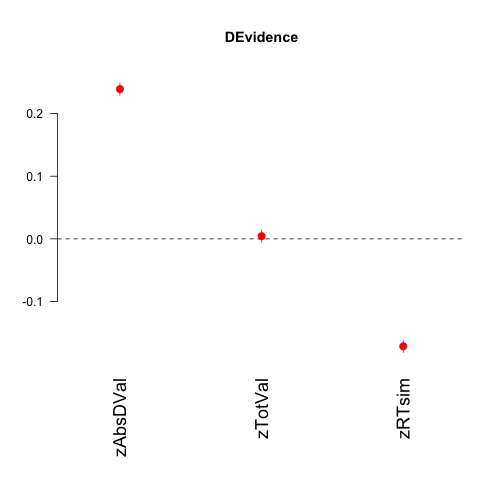

In [38]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

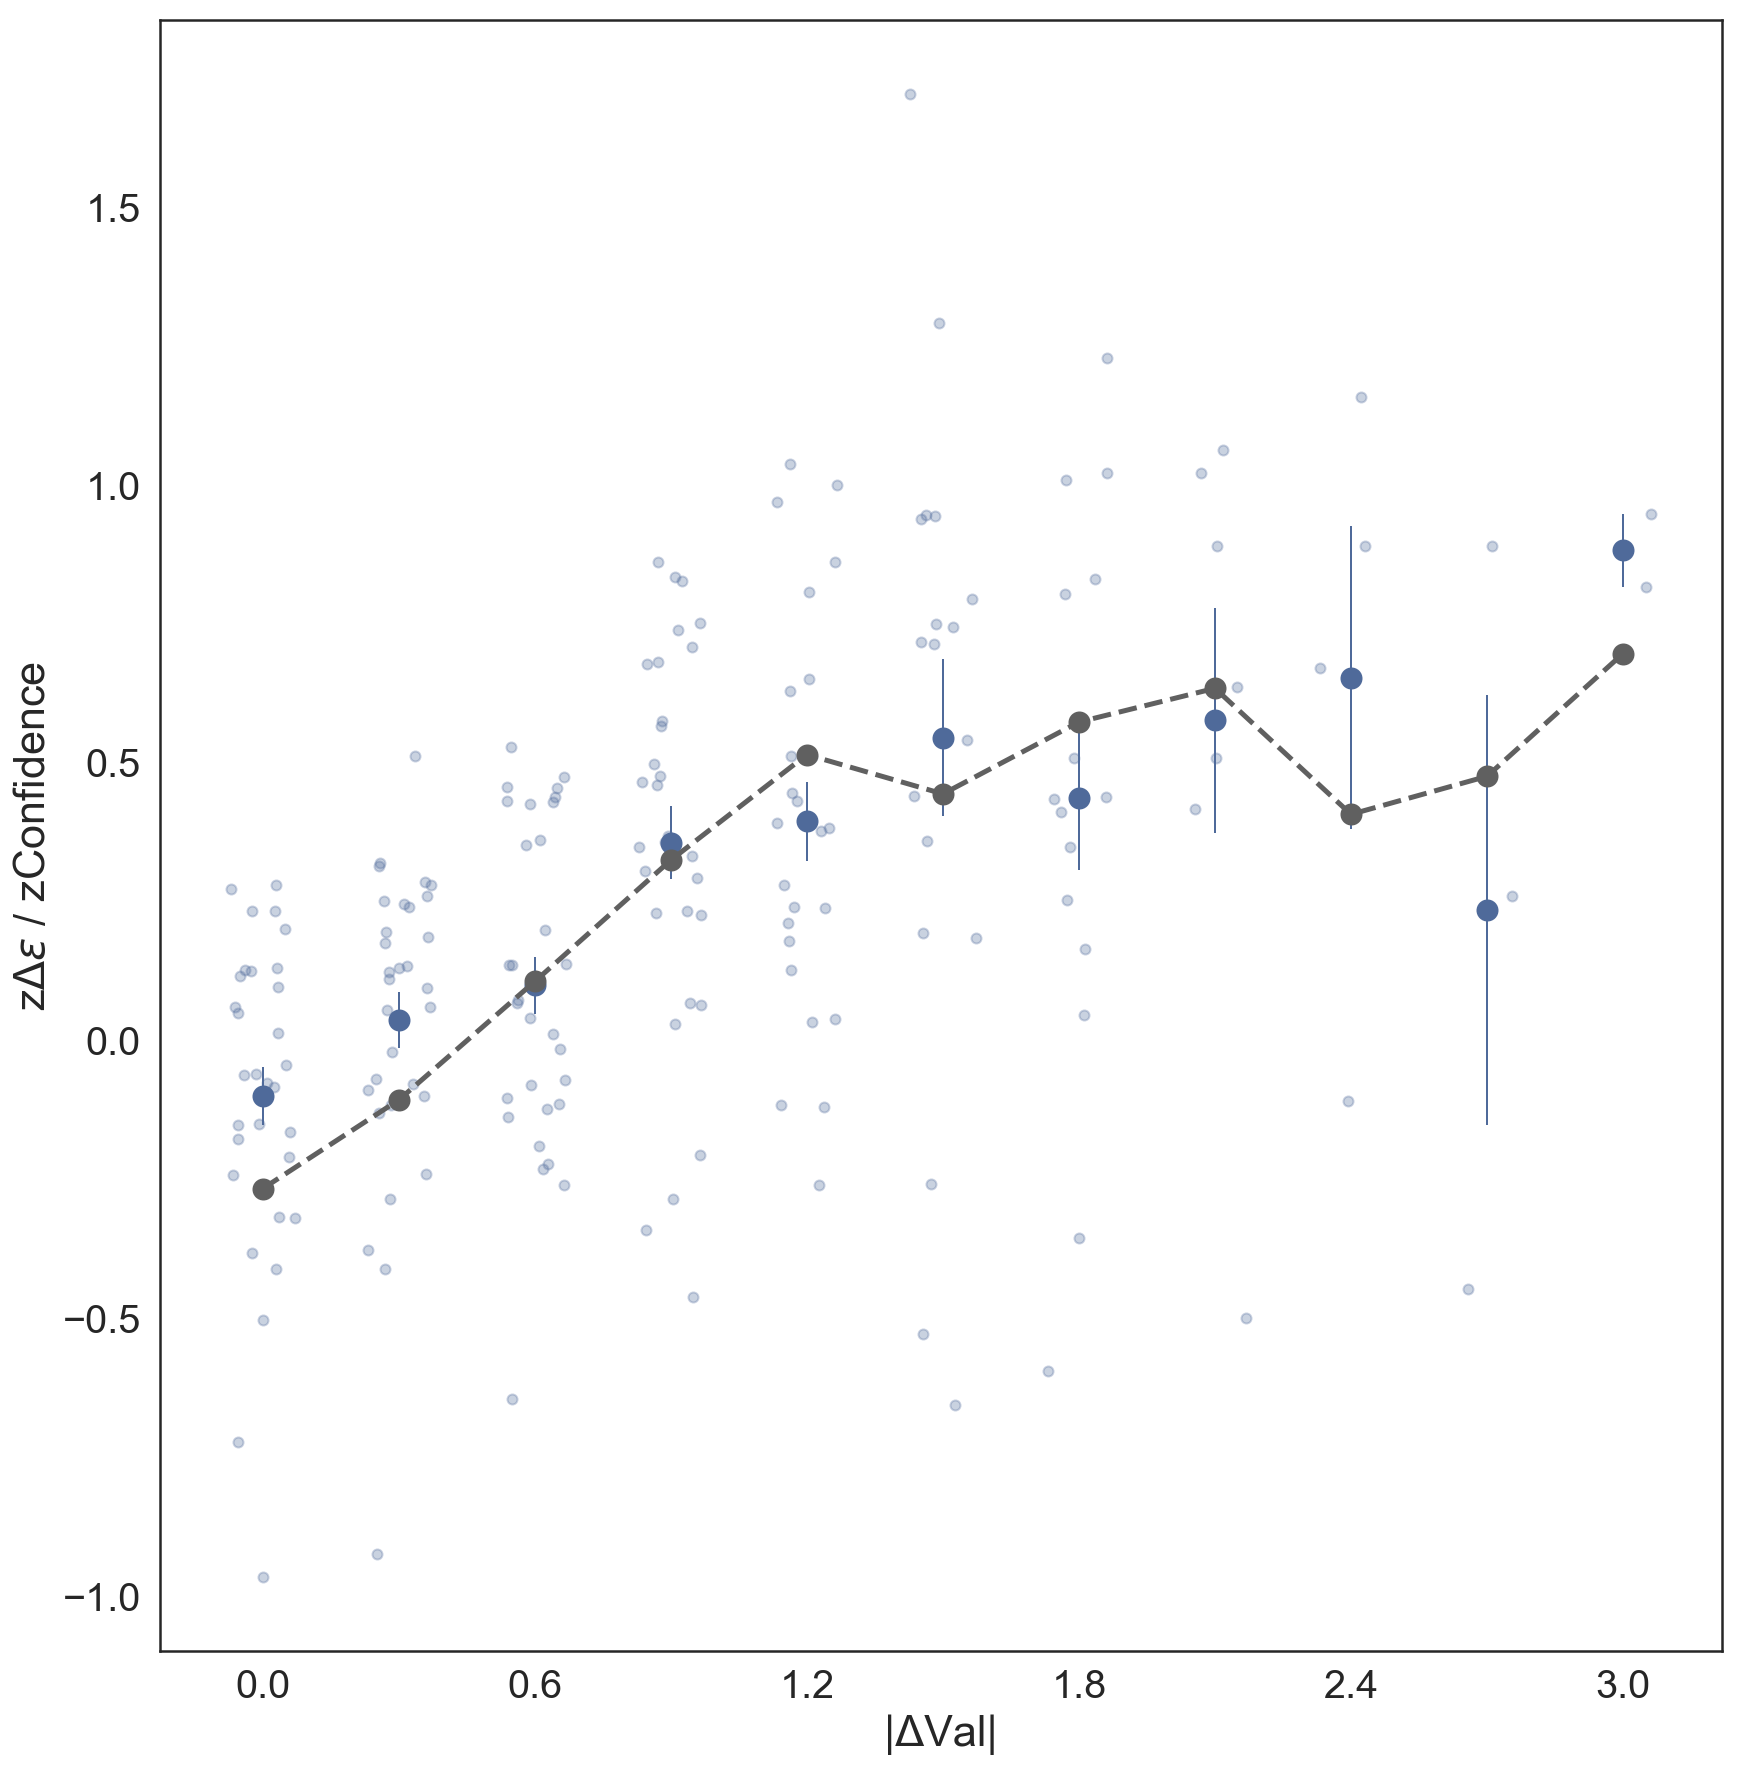

In [39]:
plot_DEv_Conf(data_simulation2, xlabel_skip=2,color1 = '#4F6A9A')

Done with TotVal


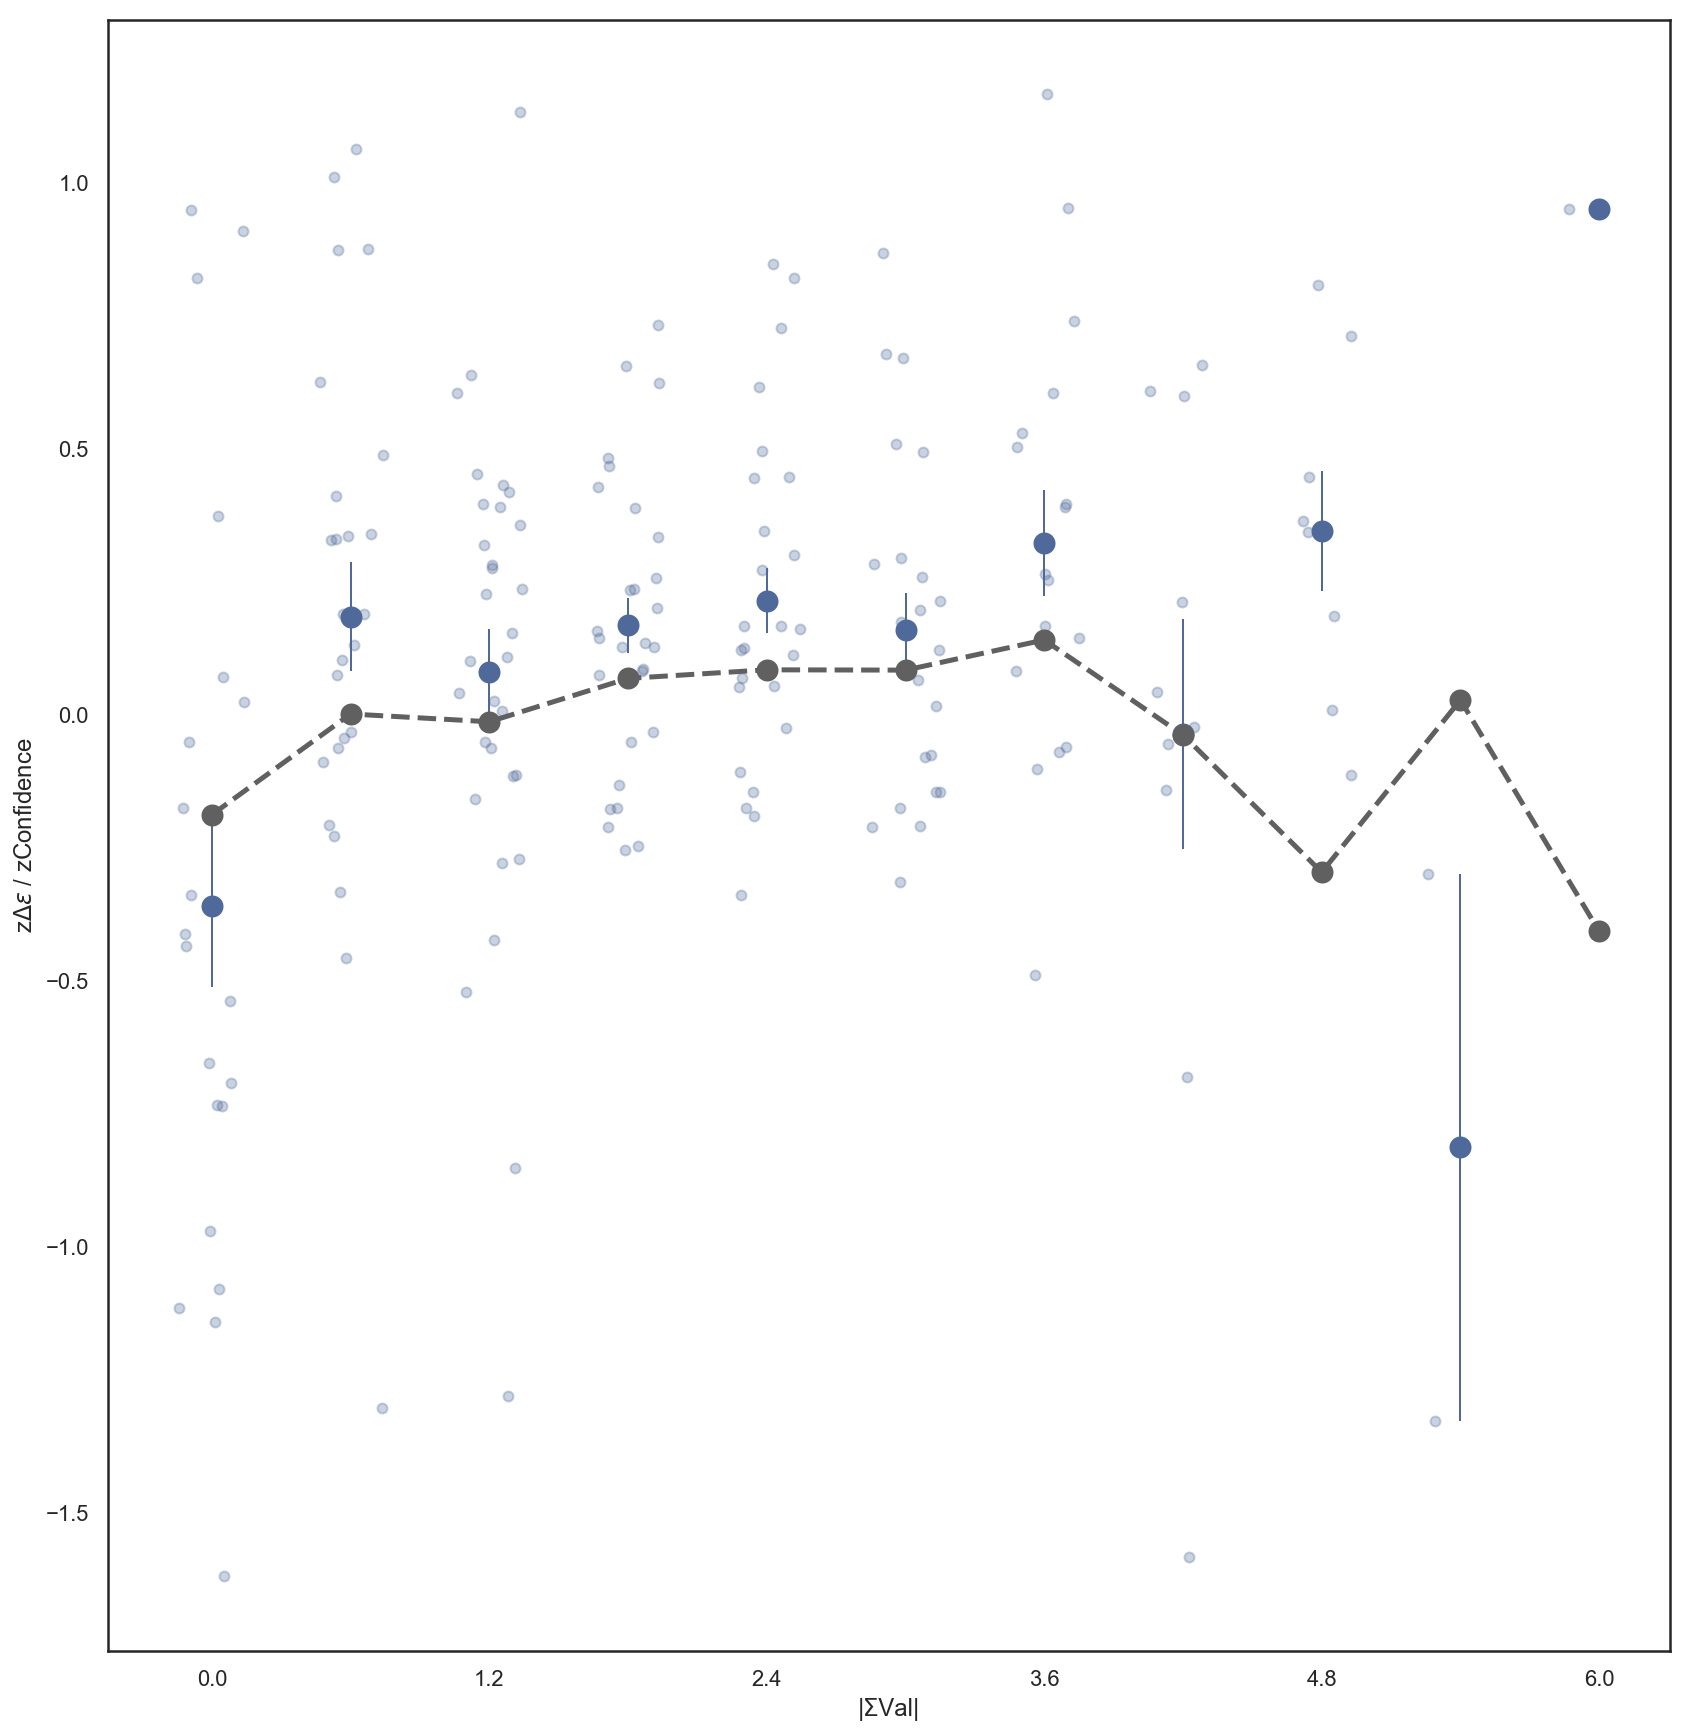

In [40]:
plot_DEv_Conf_TotVal(data_simulation2, xlabel_skip=2,color1 = '#4F6A9A')

- ---- -----------------------------------------------------------------------------------

# Dislike condition


## Load parameter estimates for participants


Use the parameter estimates from GLAM fit for Like, Binned data

In [41]:
sufix = '_Dislike_NoBin_Dislike_NUTS_Inv_31'
glam_full = glam.GLAM(data)
glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))
glam_full.estimates = pd.DataFrame.from_dict(glam_full.estimates.item(0))
params_part = glam_full.estimates

In [42]:
params_part

,gamma_mu,gamma,p_error,gamma_sd,tau_sd,v_mu,b,SNR_sd,v_sd,tau_mu,tau,t0,v,s,SNR_mu,SNR
0,-0.09,0.53,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,3.45,0.0,0.000039,0.005929,186.55,175.47
1,-0.09,0.73,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,2.18,0.0,0.000050,0.010297,186.55,200.96
2,-0.09,0.97,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,0.93,0.0,0.000042,0.007670,186.55,159.54
3,-0.09,-0.05,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,2.92,0.0,0.000037,0.007801,186.55,178.00
4,-0.09,0.18,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,4.10,0.0,0.000050,0.009849,186.55,186.73
5,-0.09,0.27,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,3.45,0.0,0.000047,0.008528,186.55,173.28
6,-0.09,0.21,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,1.81,0.0,0.000055,0.009641,186.55,145.49
7,-0.09,-0.09,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,3.79,0.0,0.000042,0.007573,186.55,159.34
8,-0.09,-0.67,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,3.15,0.0,0.000047,0.008367,186.55,160.79
9,-0.09,-0.67,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,4.68,0.0,0.000052,0.007714,186.55,124.54


# Run drift simulations for selected values and parameters

#  1. Including gaze information in the simulation 

In [43]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_dislike_31_part.csv')):  
        data_simulation = pd.read_csv("results/simulations_evidence/DEvidence_simulations_dislike_31_part.csv")

In [44]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 0 # We DO want to use the gaze from the particpants

In [45]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_dislike_31_part.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    part_id = data_all2['Part'].unique()
    
    for i in (data2['subject'].unique()):    
        for k in range(0,repeat_extra) :
            PartData = data2.loc[data2['subject'] == i] # dataframe including participant GLAM data
            PartDataAll = data_all2.loc[data_all2['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
                
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])
            
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))
        
    data_simulation =  pd.DataFrame()
    data_simulation["Part"] = Part_number
    data_simulation["LVal"] = LVal
    data_simulation["RVal"] = RVal
    data_simulation["LGaze"] = LGaze
    data_simulation["RGaze"] = RGaze
    data_simulation["AbsDVal"] = absDVal
    data_simulation["TotVal"] = TotVal
    data_simulation["AbsDEv"] = AbsDEvid
    data_simulation["RTsim"] = RT_sim
    data_simulation["Correct_sim"] = Correct_sim
    data_simulation["Choice_sim"] = Choice_sim
    data_simulation["Conf_human"] = Conf_human
    data_simulation["zConf_human"] = zConf_human
    
    data_simulation["zLVal"] = z_score1(data_simulation,'Part',"LVal")
    data_simulation["zRVal"] = z_score1(data_simulation,'Part',"RVal")
    data_simulation["zAbsDVal"] = z_score1(data_simulation,'Part',"AbsDVal")
    data_simulation["zTotVal"] = z_score1(data_simulation,'Part',"TotVal")
    data_simulation["zAbsDEv"] = z_score1(data_simulation,'Part',"AbsDEv")
    data_simulation["zRTsim"] = z_score1(data_simulation,'Part',"RTsim")

In [46]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_dislike_31_part.csv')):   
        data_simulation.to_csv("results/simulations_evidence/DEvidence_simulations_dislike_31_part.csv")

In [47]:
data_simulation

,Unnamed: 0,Part,LVal,RVal,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,0,2.05,1.00,1.05,3.05,1.063943,5989.0,1,0.0,72,-0.016206,1.237881,-1.136137,1.517553,0.071287,0.877702,2.442727
1,1,0,0.70,1.30,0.60,2.00,1.039295,2506.0,1,1.0,68,-0.315386,-1.814428,-0.457846,0.264528,-1.592082,0.807424,-0.593203
2,2,0,1.30,1.75,0.45,3.05,0.808732,4185.0,1,1.0,68,-0.315386,-0.457846,0.559590,-0.153148,0.071287,0.150018,0.870284
3,3,0,1.45,0.70,0.75,2.15,1.080353,2235.0,1,0.0,68,-0.315386,-0.118701,-1.814428,0.682203,-1.354458,0.924492,-0.829419
4,4,0,1.00,1.00,0.00,2.00,0.190872,6163.0,0,1.0,88,1.180516,-1.136137,-1.136137,-1.406173,-1.592082,-1.611691,2.594393
5,5,0,2.35,1.75,0.60,4.10,1.112890,2103.0,1,0.0,86,1.030926,1.916172,0.559590,0.264528,1.734657,1.017264,-0.944475
6,6,0,1.45,1.90,0.45,3.35,0.946615,4423.0,1,1.0,78,0.432565,-0.118701,0.898735,-0.153148,0.546536,0.543164,1.077735
7,7,0,2.05,2.35,0.30,4.40,0.648306,3508.0,1,1.0,72,-0.016206,1.237881,1.916172,-0.570823,2.209905,-0.307405,0.280182
8,8,0,1.45,1.30,0.15,2.75,0.381268,4848.0,0,1.0,68,-0.315386,-0.118701,-0.457846,-0.988498,-0.403961,-1.068815,1.448183
9,9,0,1.00,1.90,0.90,2.90,1.089108,3443.0,1,1.0,66,-0.464976,-1.136137,0.898735,1.099878,-0.166337,0.949455,0.223525


## Since for dislike we have that TotVal represents the inverted value we take it back to the original denomination

In [110]:
data_simulation['TotVal_orig'] = 6 - data_simulation['TotVal']
data_simulation["zTotVal_orig"] = z_score1(data_simulation,'Part',"TotVal_orig")


Pearson's r = 0.066 p =  0.0


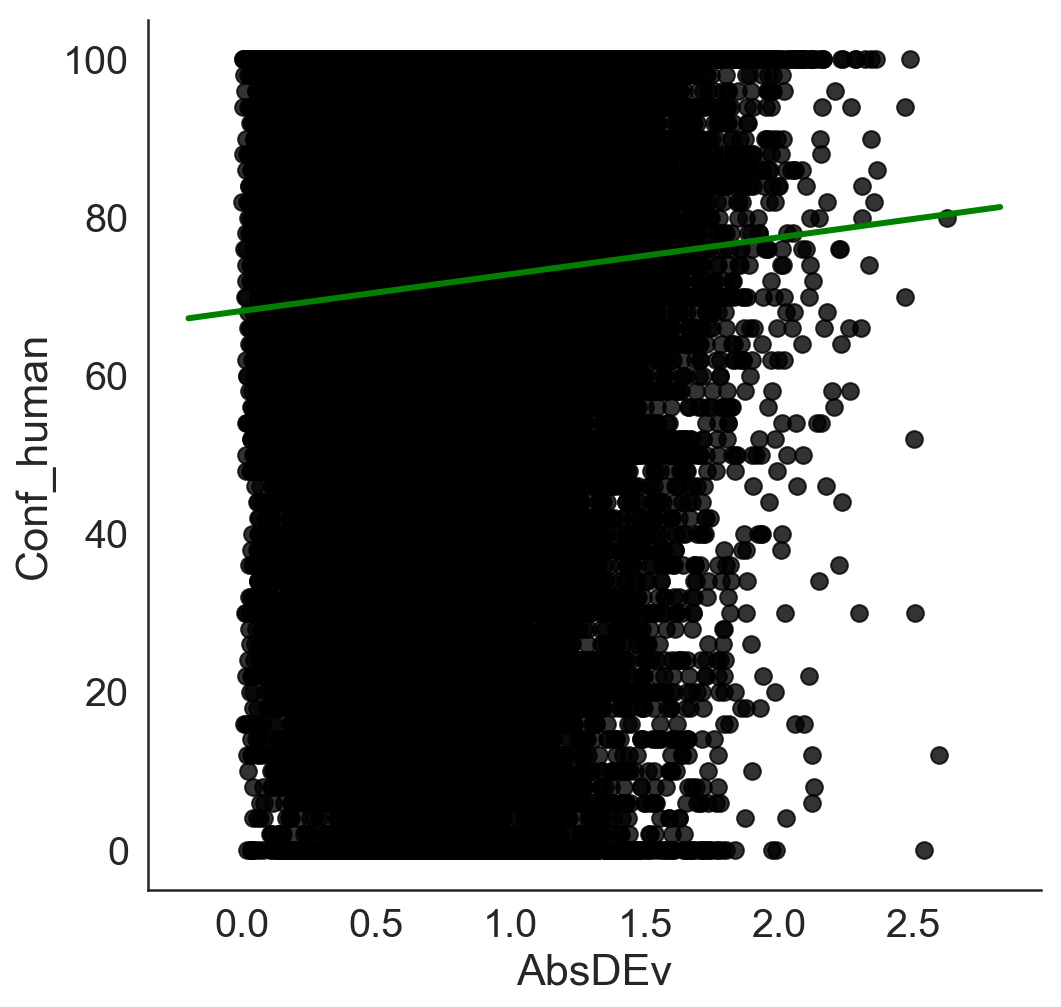

Pearson's r = 0.055 p =  0.0


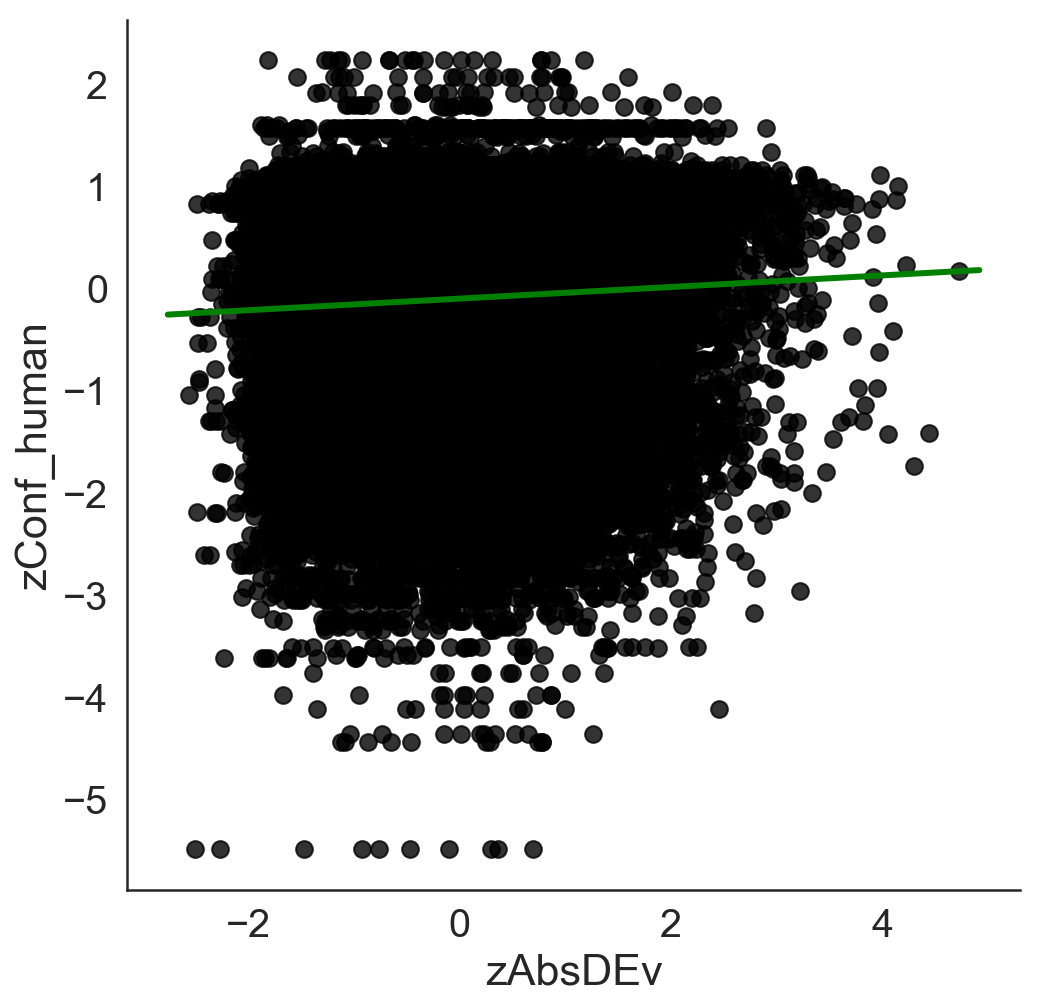

In [111]:
correl_plot(data_simulation,'AbsDEv', "AbsDEv",'Conf_human','Conf_human')
correl_plot(data_simulation,'zAbsDEv', "zAbsDEv",'zConf_human','zConf_human')

In [112]:
%%R -i data_simulation
d <- data_simulation

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 104189.7
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal_orig + zRTsim, data = d)

Coefficients:
 (Intercept)      zAbsDVal  zTotVal_orig        zRTsim  
  -3.680e-16     9.699e-02    -7.531e-02    -1.486e-01  

Degrees of Freedom: 37199 Total (i.e. Null);  37196 Residual
Null Deviance:	    37200 
Residual Deviance: 35800 	AIC: 104100


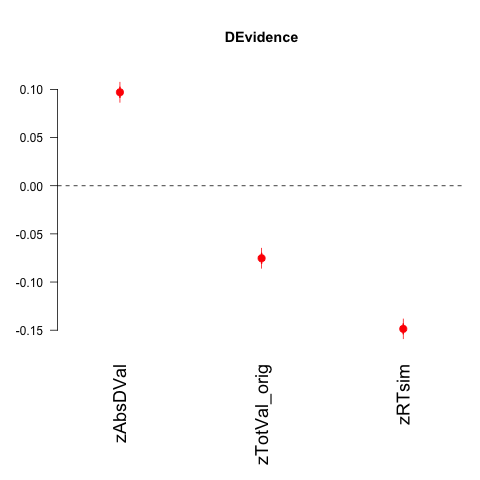

In [113]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal_orig + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

# We calculate the original regression with human data

In [102]:
%%R -i data_all2
d <- data_all2

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 10216.38
Call:  glm(formula = zConf ~ zAbsDVal + zTotVal + zRT, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal          zRT  
   -0.07089      0.18816     -0.15851     -0.30716  

Degrees of Freedom: 3719 Total (i.e. Null);  3716 Residual
Null Deviance:	    4019 
Residual Deviance: 3357 	AIC: 10190


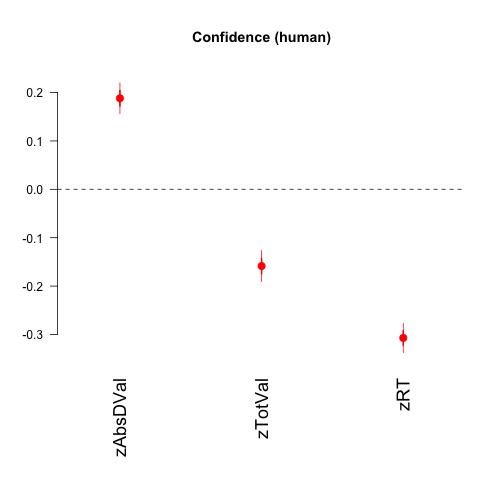

In [107]:
%%R    
title_plot = "Confidence (human)"
ModelChoice_1 <- glm(zConf ~ zAbsDVal + zTotVal + zRT  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

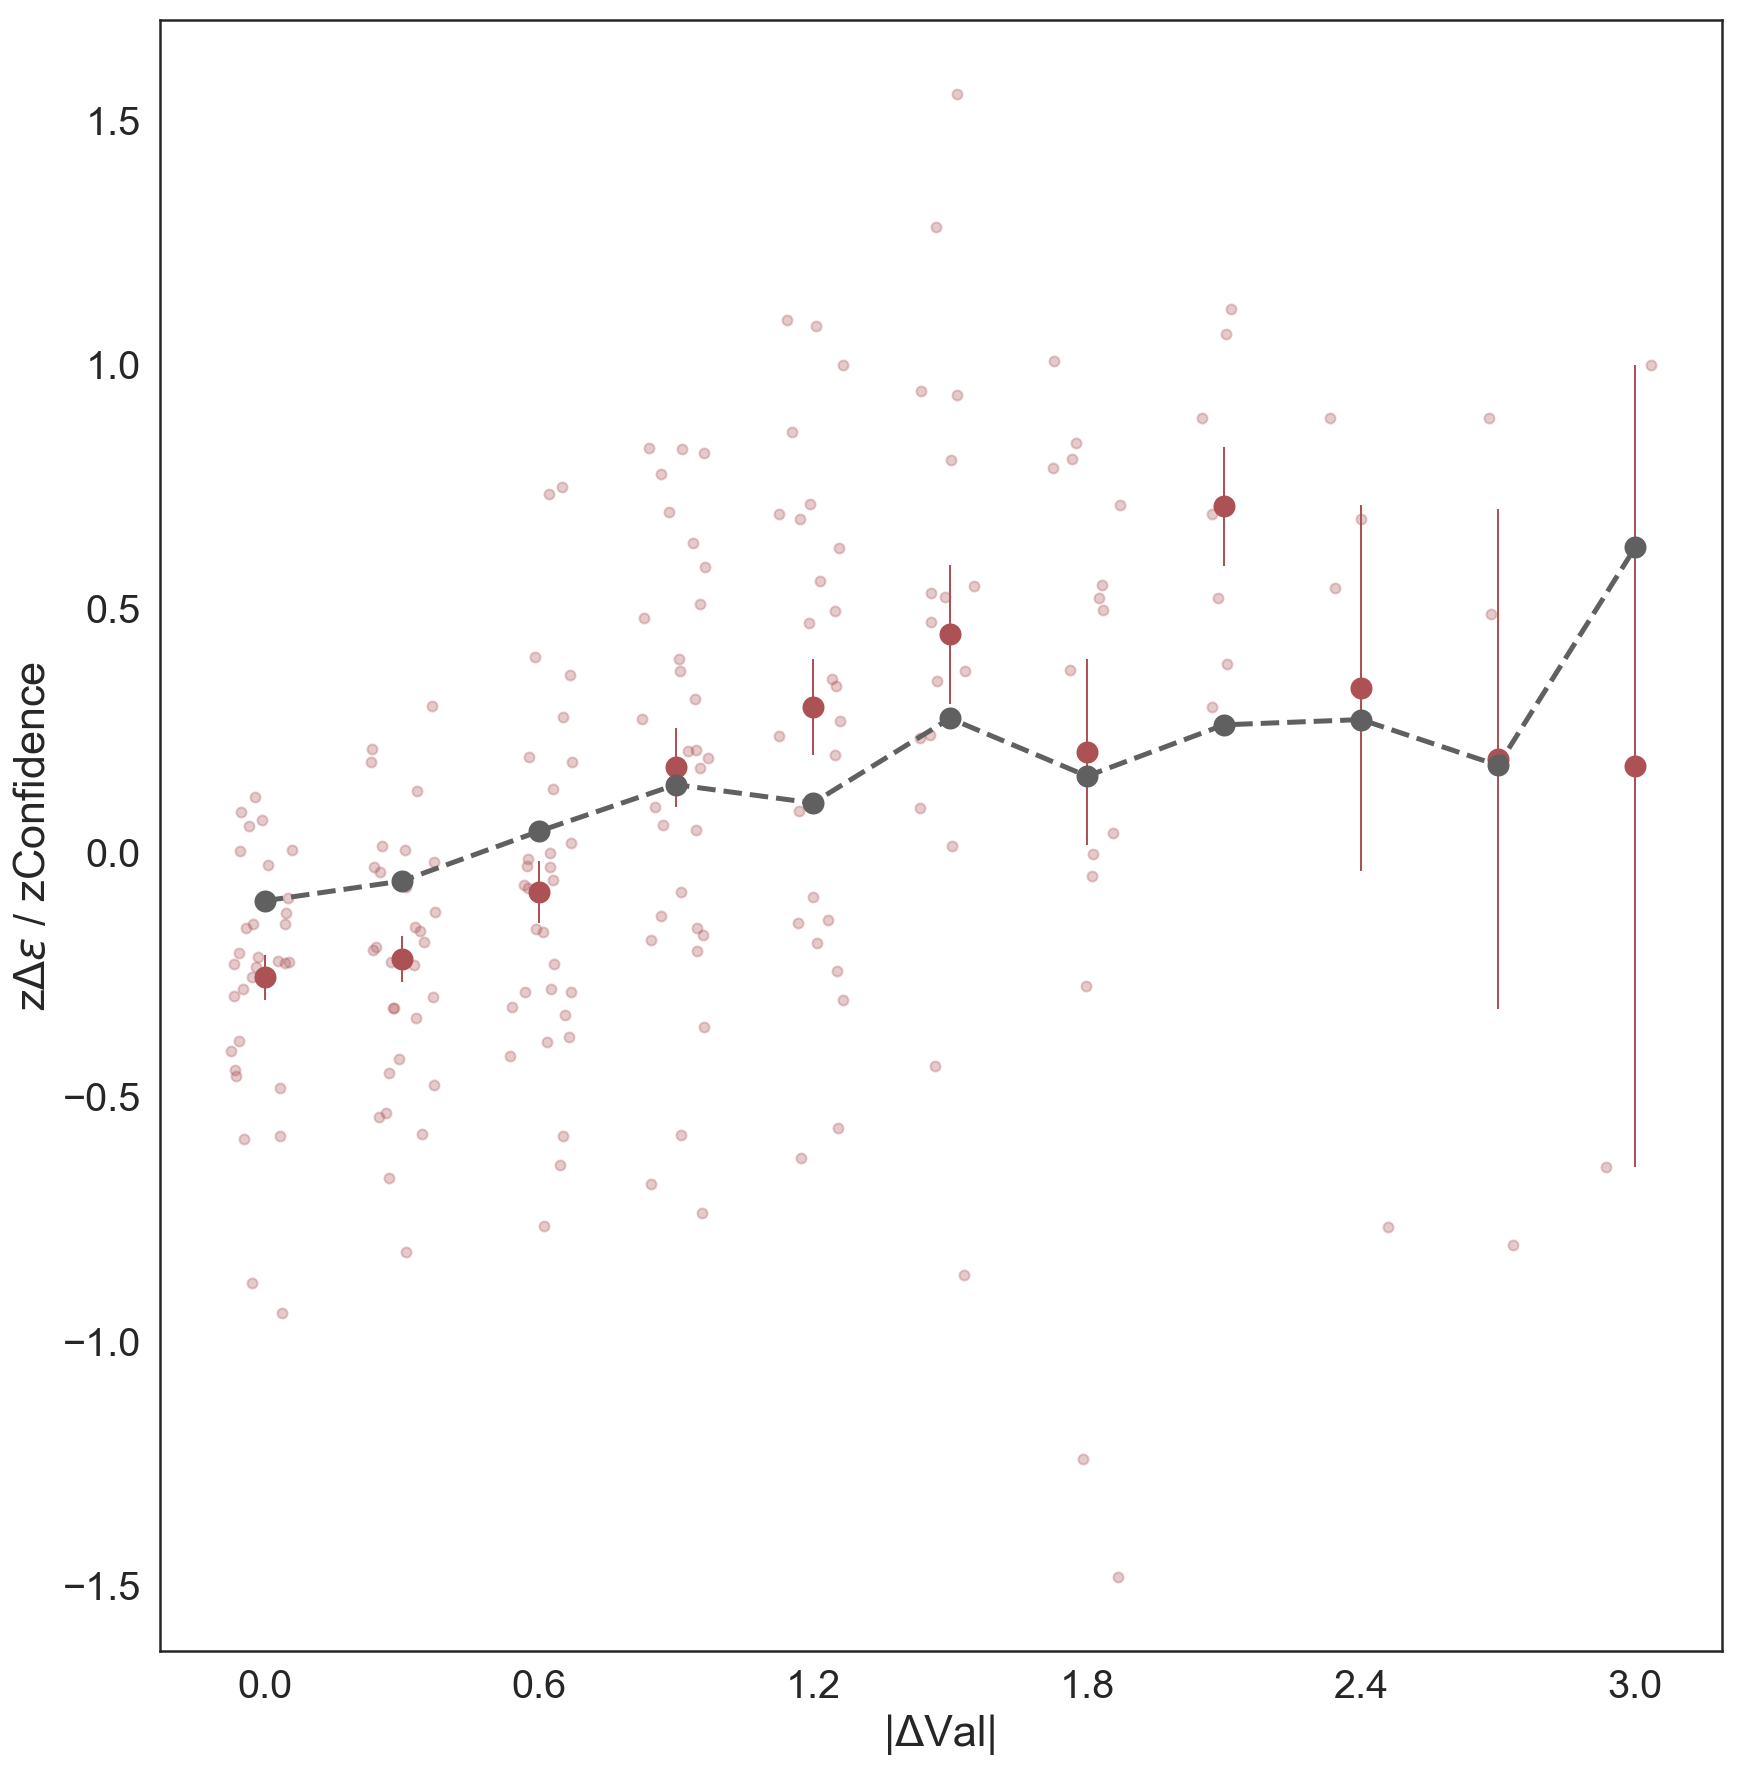

In [51]:
plot_DEv_Conf(data_simulation, xlabel_skip=2,color1 = '#AC5255')

Done with TotVal


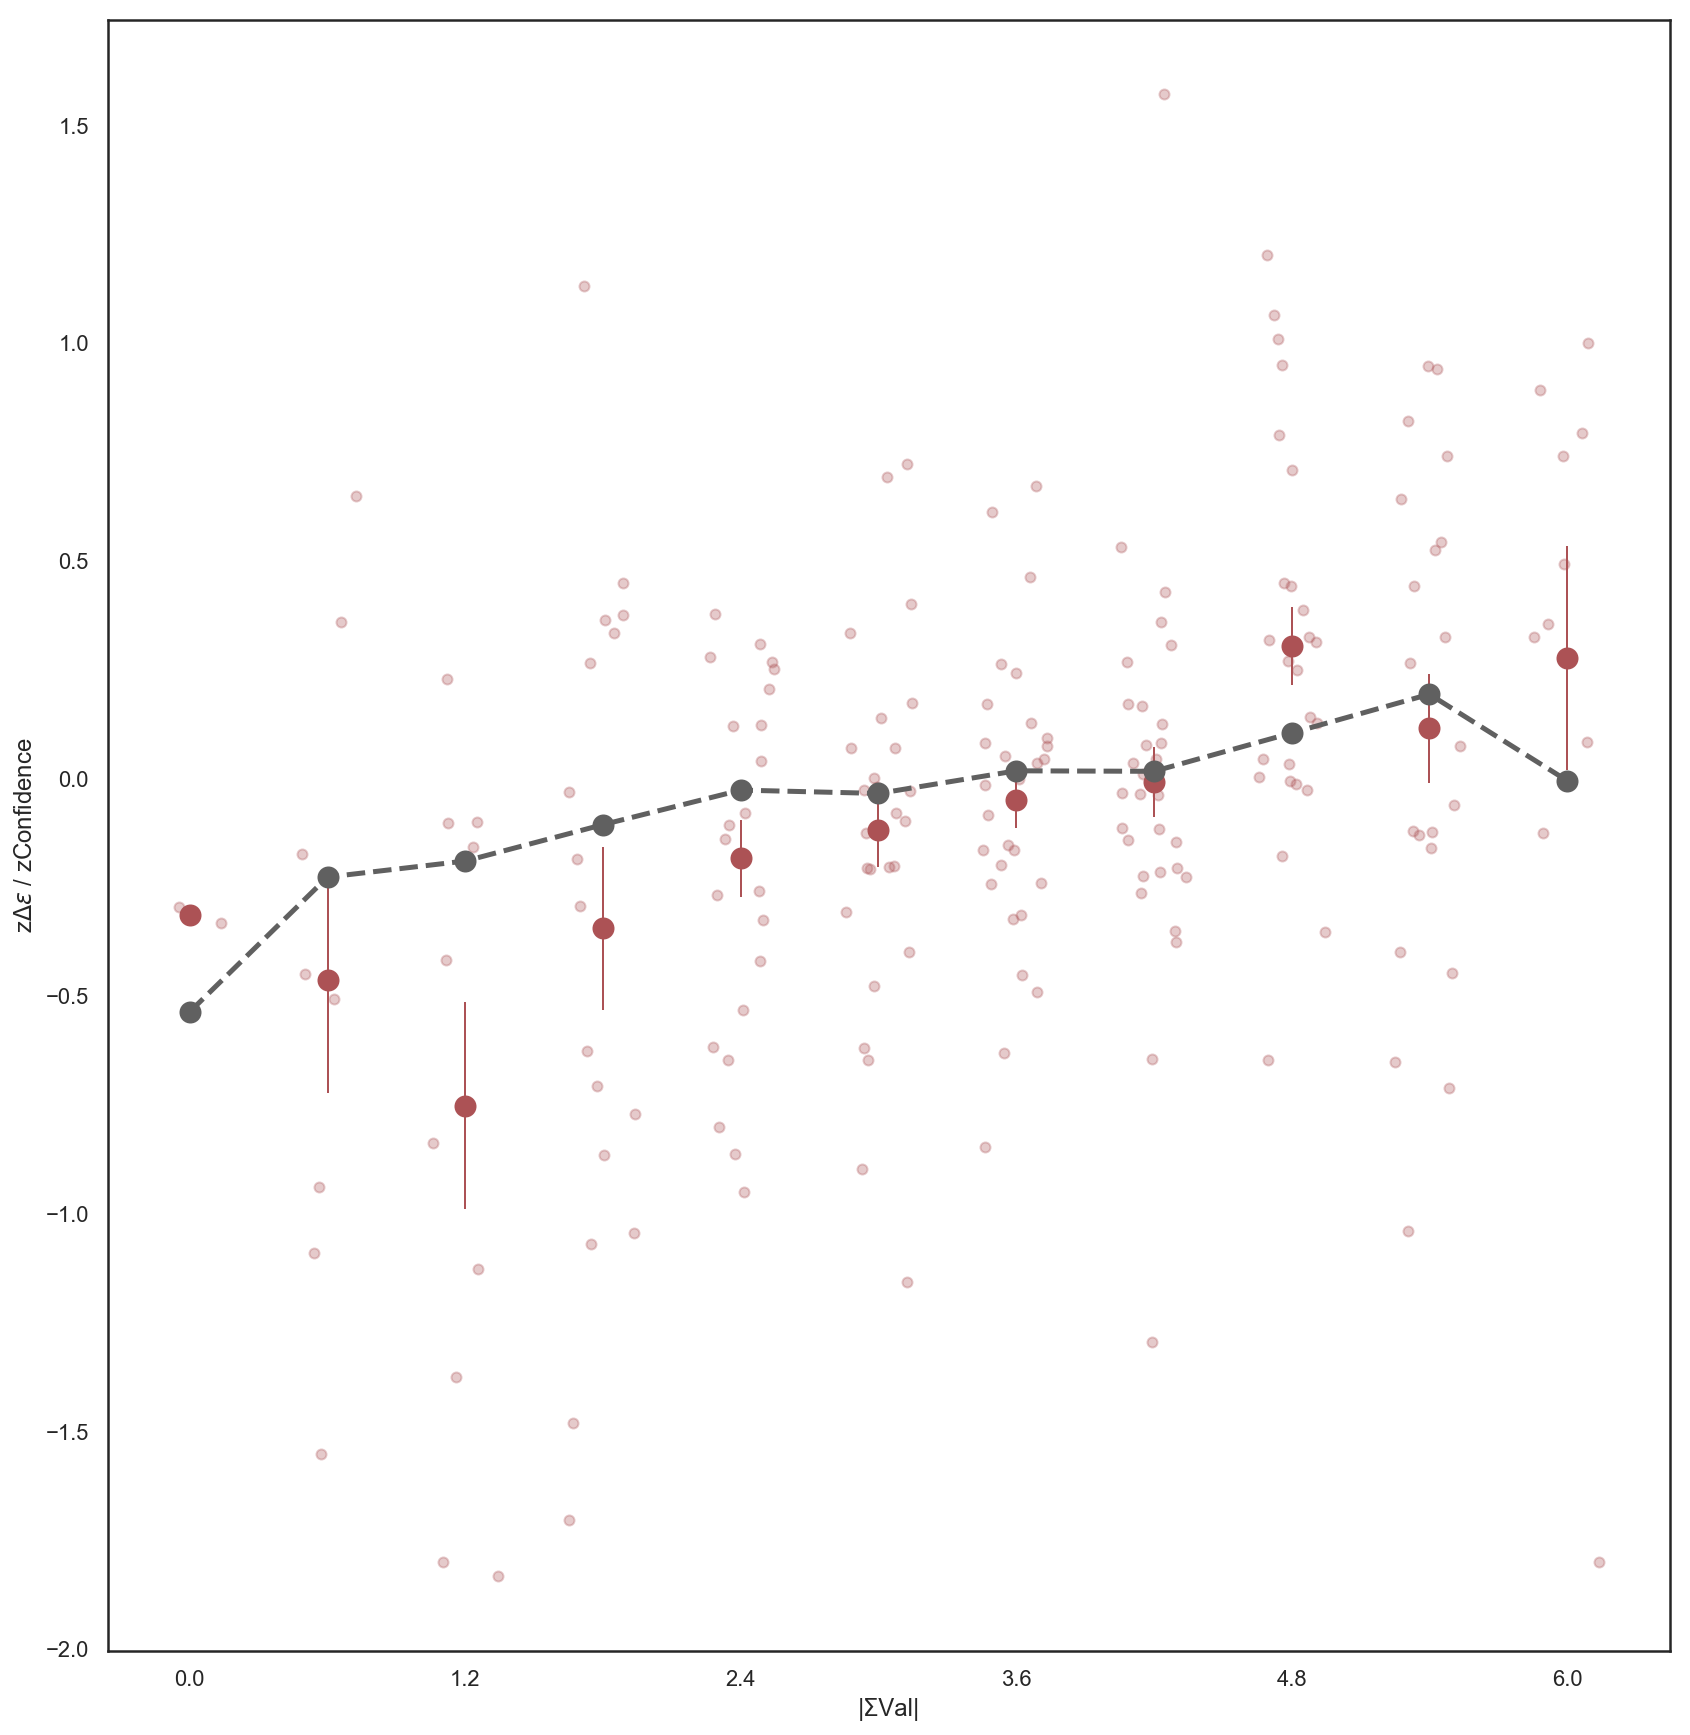

In [52]:
plot_DEv_Conf_TotVal(data_simulation, xlabel_skip=2,color1 = '#AC5255')

#  2. Excluding gaze information in the simulation 

In [53]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_dislike_31_part.csv')):  
        data_simulation2 = pd.read_csv("results/simulations_evidence/DEvidence_simulations_NoGaze_dislike_31_part.csv")

In [54]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 1 # We DON'T want to use the gaze from the particpants

In [55]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_dislike_31_part.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    value_tests = []
    gaze_tests = []
    
    part_id = data_all2['Part'].unique()
    
    for i in (data2['subject'].unique()):    
        for k in range(0,repeat_extra) :
            PartData = data2.loc[data2['subject'] == i] # dataframe including participant GLAM data
            PartDataAll = data_all2.loc[data_all2['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
              #  gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))
                gaze_tests = [0, 0] # To test why it's crashing

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])

                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))

    data_simulation2 =  pd.DataFrame()
    
    data_simulation2["Part"] = Part_number
    data_simulation2["LVal"] = LVal
    data_simulation2["RVal"] = RVal
    data_simulation2["LGaze"] = LGaze
    data_simulation2["RGaze"] = RGaze
    data_simulation2["AbsDVal"] = absDVal
    data_simulation2["TotVal"] = TotVal
    data_simulation2["AbsDEv"] = AbsDEvid
    data_simulation2["RTsim"] = RT_sim
    data_simulation2["Correct_sim"] = Correct_sim
    data_simulation2["Choice_sim"] = Choice_sim
    data_simulation2["Conf_human"] = Conf_human
    data_simulation2["zConf_human"] = zConf_human
    

subj 0
subj 1
subj 2
subj 3
subj 4
subj 5
subj 6
subj 7
subj 8
subj 9
subj 10
subj 11
subj 12
subj 13
subj 14
subj 15
subj 16
subj 17
subj 18
subj 19
subj 20
subj 21
subj 22
subj 23
subj 24
subj 25
subj 26
subj 27
subj 28
subj 29
subj 30


In [56]:
data_simulation2["zLVal"] = z_score1(data_simulation2,'Part',"LVal")
data_simulation2["zRVal"] = z_score1(data_simulation2,'Part',"RVal")
data_simulation2["zAbsDVal"] = z_score1(data_simulation2,'Part',"AbsDVal")
data_simulation2["zTotVal"] = z_score1(data_simulation2,'Part',"TotVal")
data_simulation2["zAbsDEv"] = z_score1(data_simulation2,'Part',"AbsDEv")
data_simulation2["zRTsim"] = z_score1(data_simulation2,'Part',"RTsim")

In [57]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_dislike_31_part.csv')):   
        data_simulation2.to_csv("results/simulations_evidence/DEvidence_simulations_NoGaze_dislike_31_part.csv")

In [58]:
data_simulation2

,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,2.05,1.00,0.5,0.5,1.05,3.05,1.608354,3293.0,1,0.0,72,-0.016206,1.237881,-1.136137,1.517553,0.071287,2.534806,-0.033921
1,0,0.70,1.30,0.5,0.5,0.60,2.00,0.314937,5659.0,1,1.0,68,-0.315386,-1.814428,-0.457846,0.264528,-1.592082,-1.084469,1.849940
2,0,1.30,1.75,0.5,0.5,0.45,3.05,0.887858,2814.0,1,1.0,68,-0.315386,-0.457846,0.559590,-0.153148,0.071287,0.518695,-0.415311
3,0,1.45,0.70,0.5,0.5,0.75,2.15,0.301275,4123.0,1,0.0,68,-0.315386,-0.118701,-1.814428,0.682203,-1.354458,-1.122696,0.626943
4,0,1.00,1.00,0.5,0.5,0.00,2.00,0.117528,7066.0,0,0.0,88,1.180516,-1.136137,-1.136137,-1.406173,-1.592082,-1.636864,2.970225
5,0,2.35,1.75,0.5,0.5,0.60,4.10,0.612093,2663.0,1,0.0,86,1.030926,1.916172,0.559590,0.264528,1.734657,-0.252959,-0.535541
6,0,1.45,1.90,0.5,0.5,0.45,3.35,0.340315,3748.0,1,1.0,78,0.432565,-0.118701,0.898735,-0.153148,0.546536,-1.013454,0.328360
7,0,2.05,2.35,0.5,0.5,0.30,4.40,1.058388,2534.0,1,1.0,72,-0.016206,1.237881,1.916172,-0.570823,2.209905,0.995878,-0.638254
8,0,1.45,1.30,0.5,0.5,0.15,2.75,0.361399,5506.0,1,0.0,68,-0.315386,-0.118701,-0.457846,-0.988498,-0.403961,-0.954457,1.728118
9,0,1.00,1.90,0.5,0.5,0.90,2.90,1.000722,2389.0,1,1.0,66,-0.464976,-1.136137,0.898735,1.099878,-0.166337,0.834515,-0.753706


## Since for dislike we have that TotVal represents the inverted value we take it back to the original denomination

In [115]:
data_simulation2['TotVal_orig'] = 6 - data_simulation['TotVal']
data_simulation2["zTotVal_orig"] = z_score1(data_simulation,'Part',"TotVal_orig")


Pearson's r = 0.046 p =  0.0


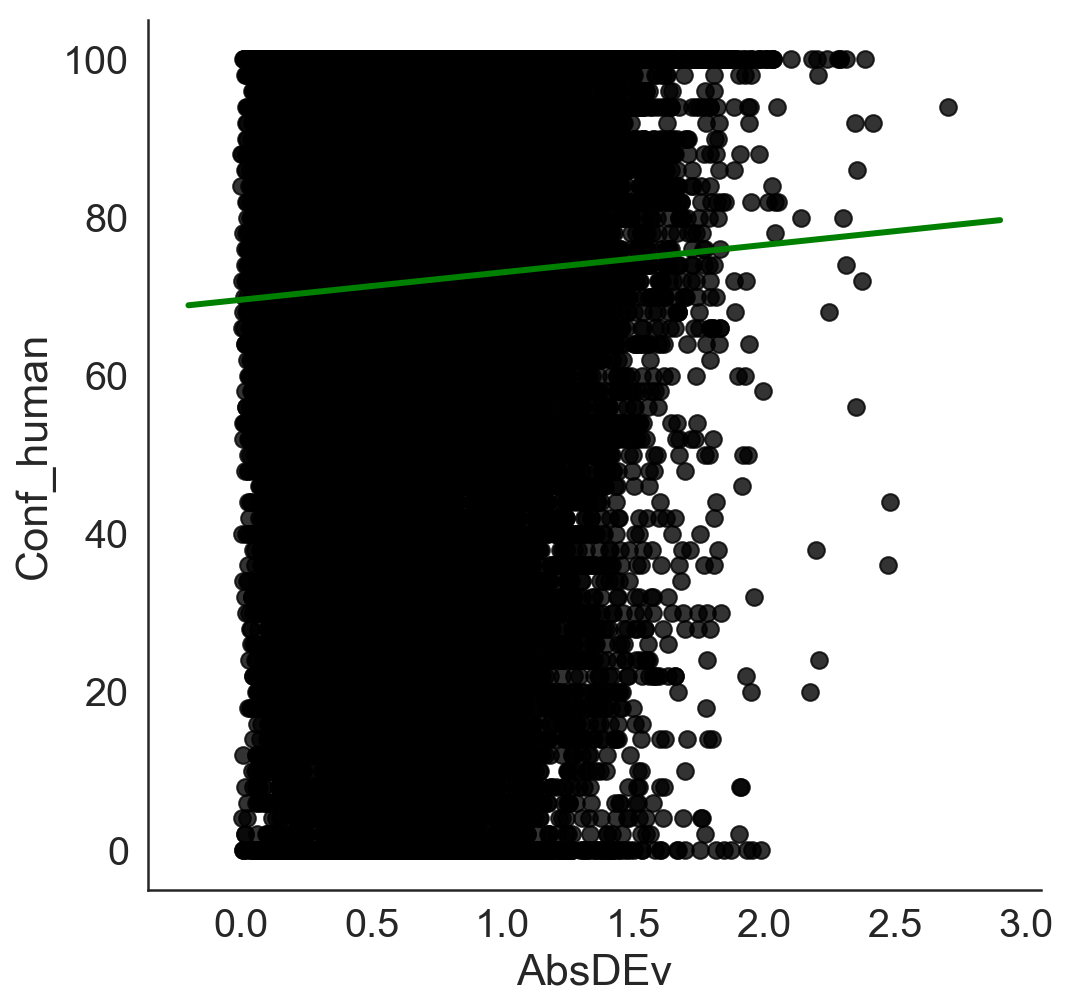

Pearson's r = 0.063 p =  0.0


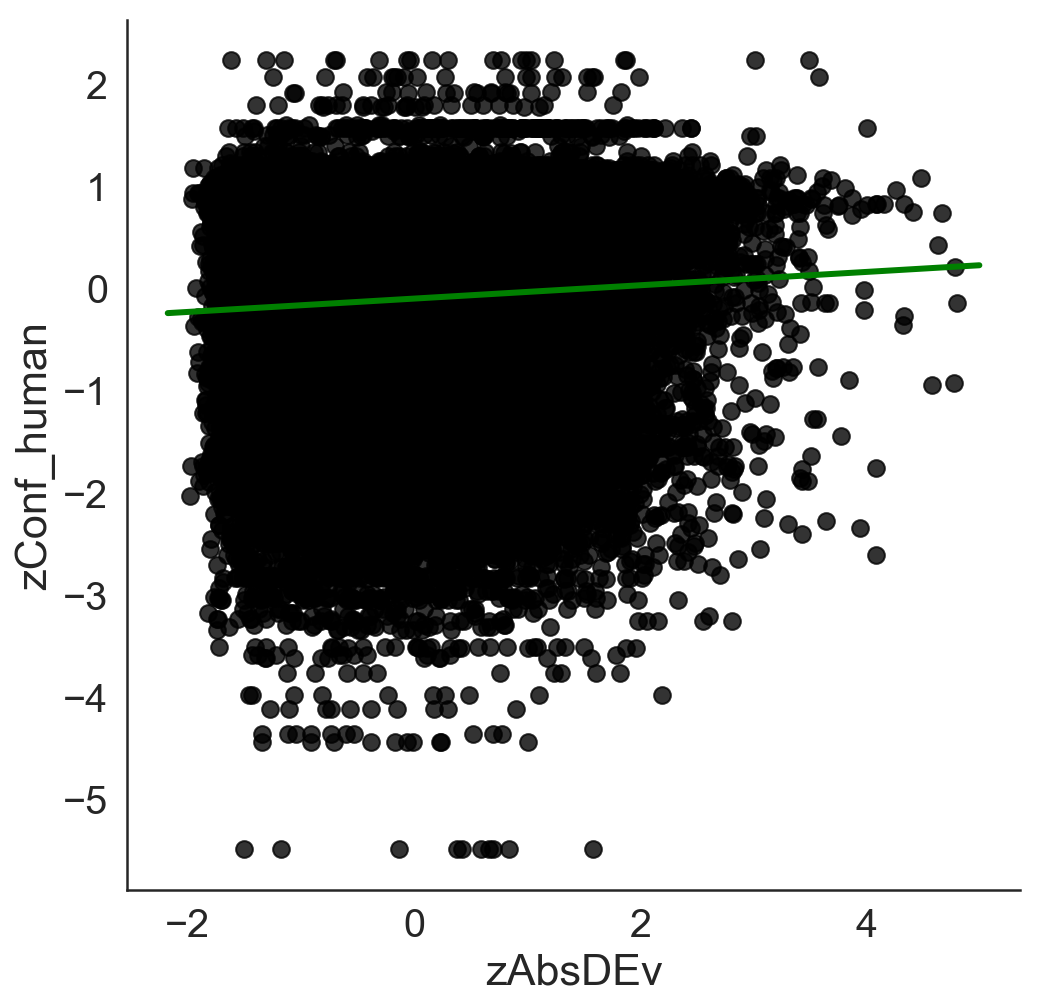

In [116]:
correl_plot(data_simulation2,'AbsDEv', "AbsDEv",'Conf_human','Conf_human')
correl_plot(data_simulation2,'zAbsDEv', "zAbsDEv",'zConf_human','zConf_human')

In [117]:
%%R -i data_simulation2
d <- data_simulation2

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 102773.2
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal_orig + zRTsim, data = d)

Coefficients:
 (Intercept)      zAbsDVal  zTotVal_orig        zRTsim  
  -4.321e-16     2.086e-01    -5.365e-03    -1.472e-01  

Degrees of Freedom: 37199 Total (i.e. Null);  37196 Residual
Null Deviance:	    37200 
Residual Deviance: 34460 	AIC: 102700


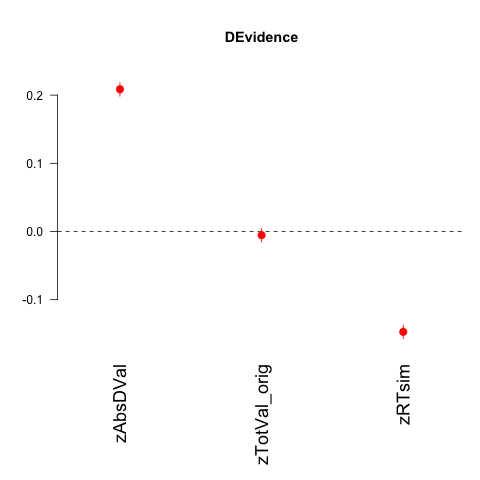

In [118]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal_orig + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

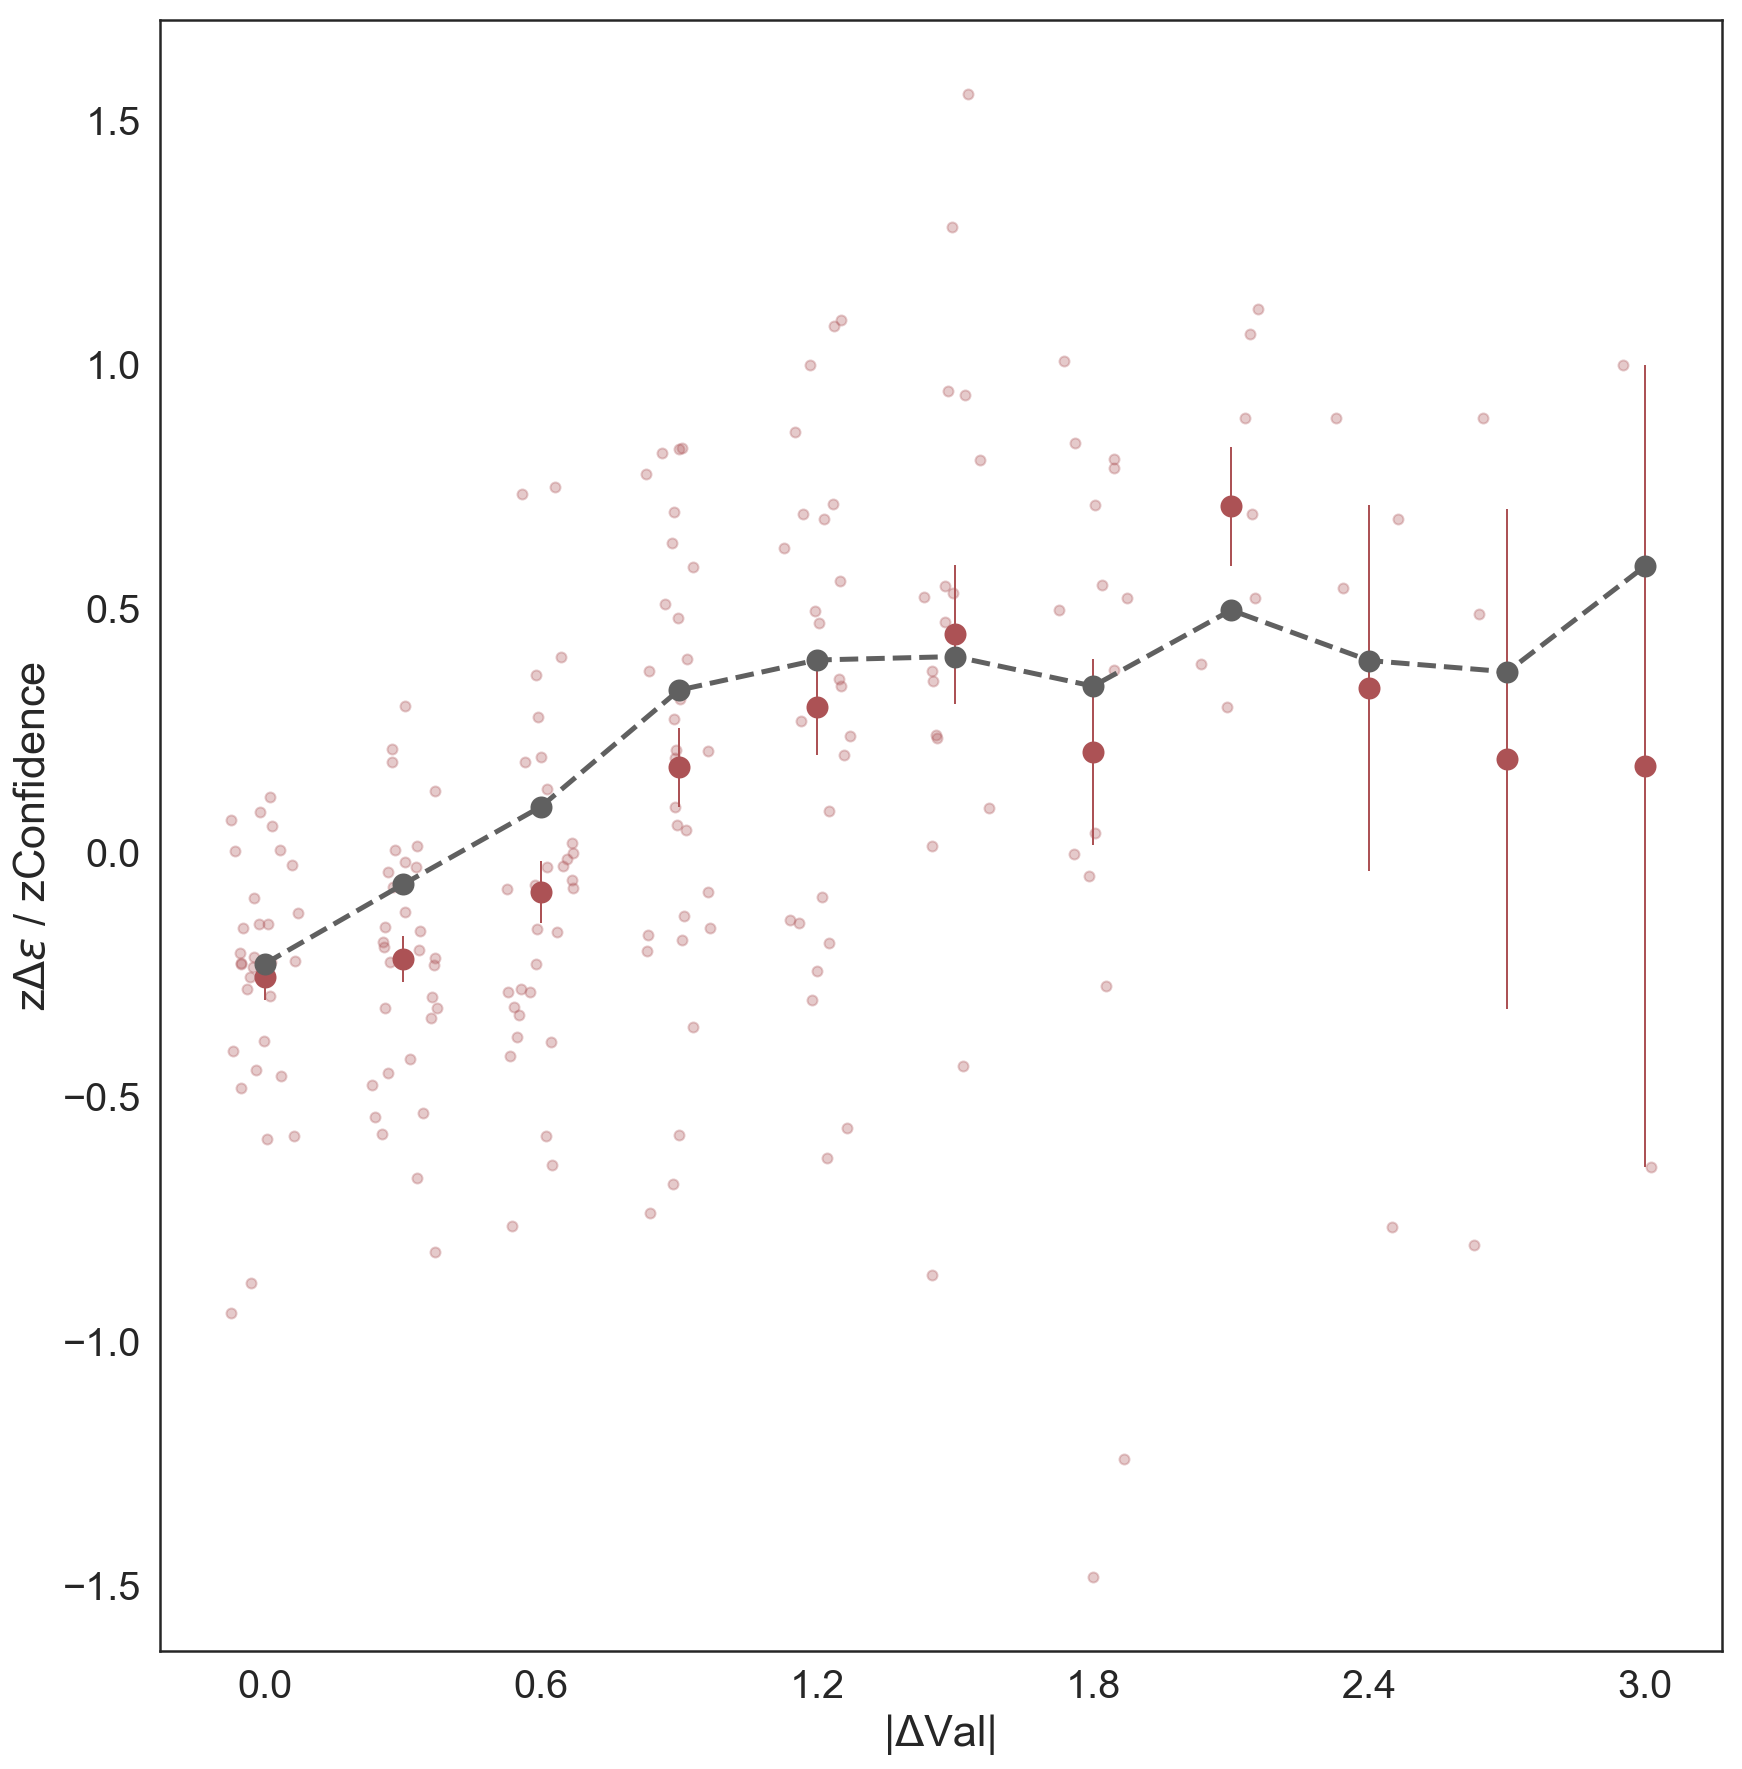

In [119]:
plot_DEv_Conf(data_simulation2, xlabel_skip=2,color1 = '#AC5255')

Done with TotVal


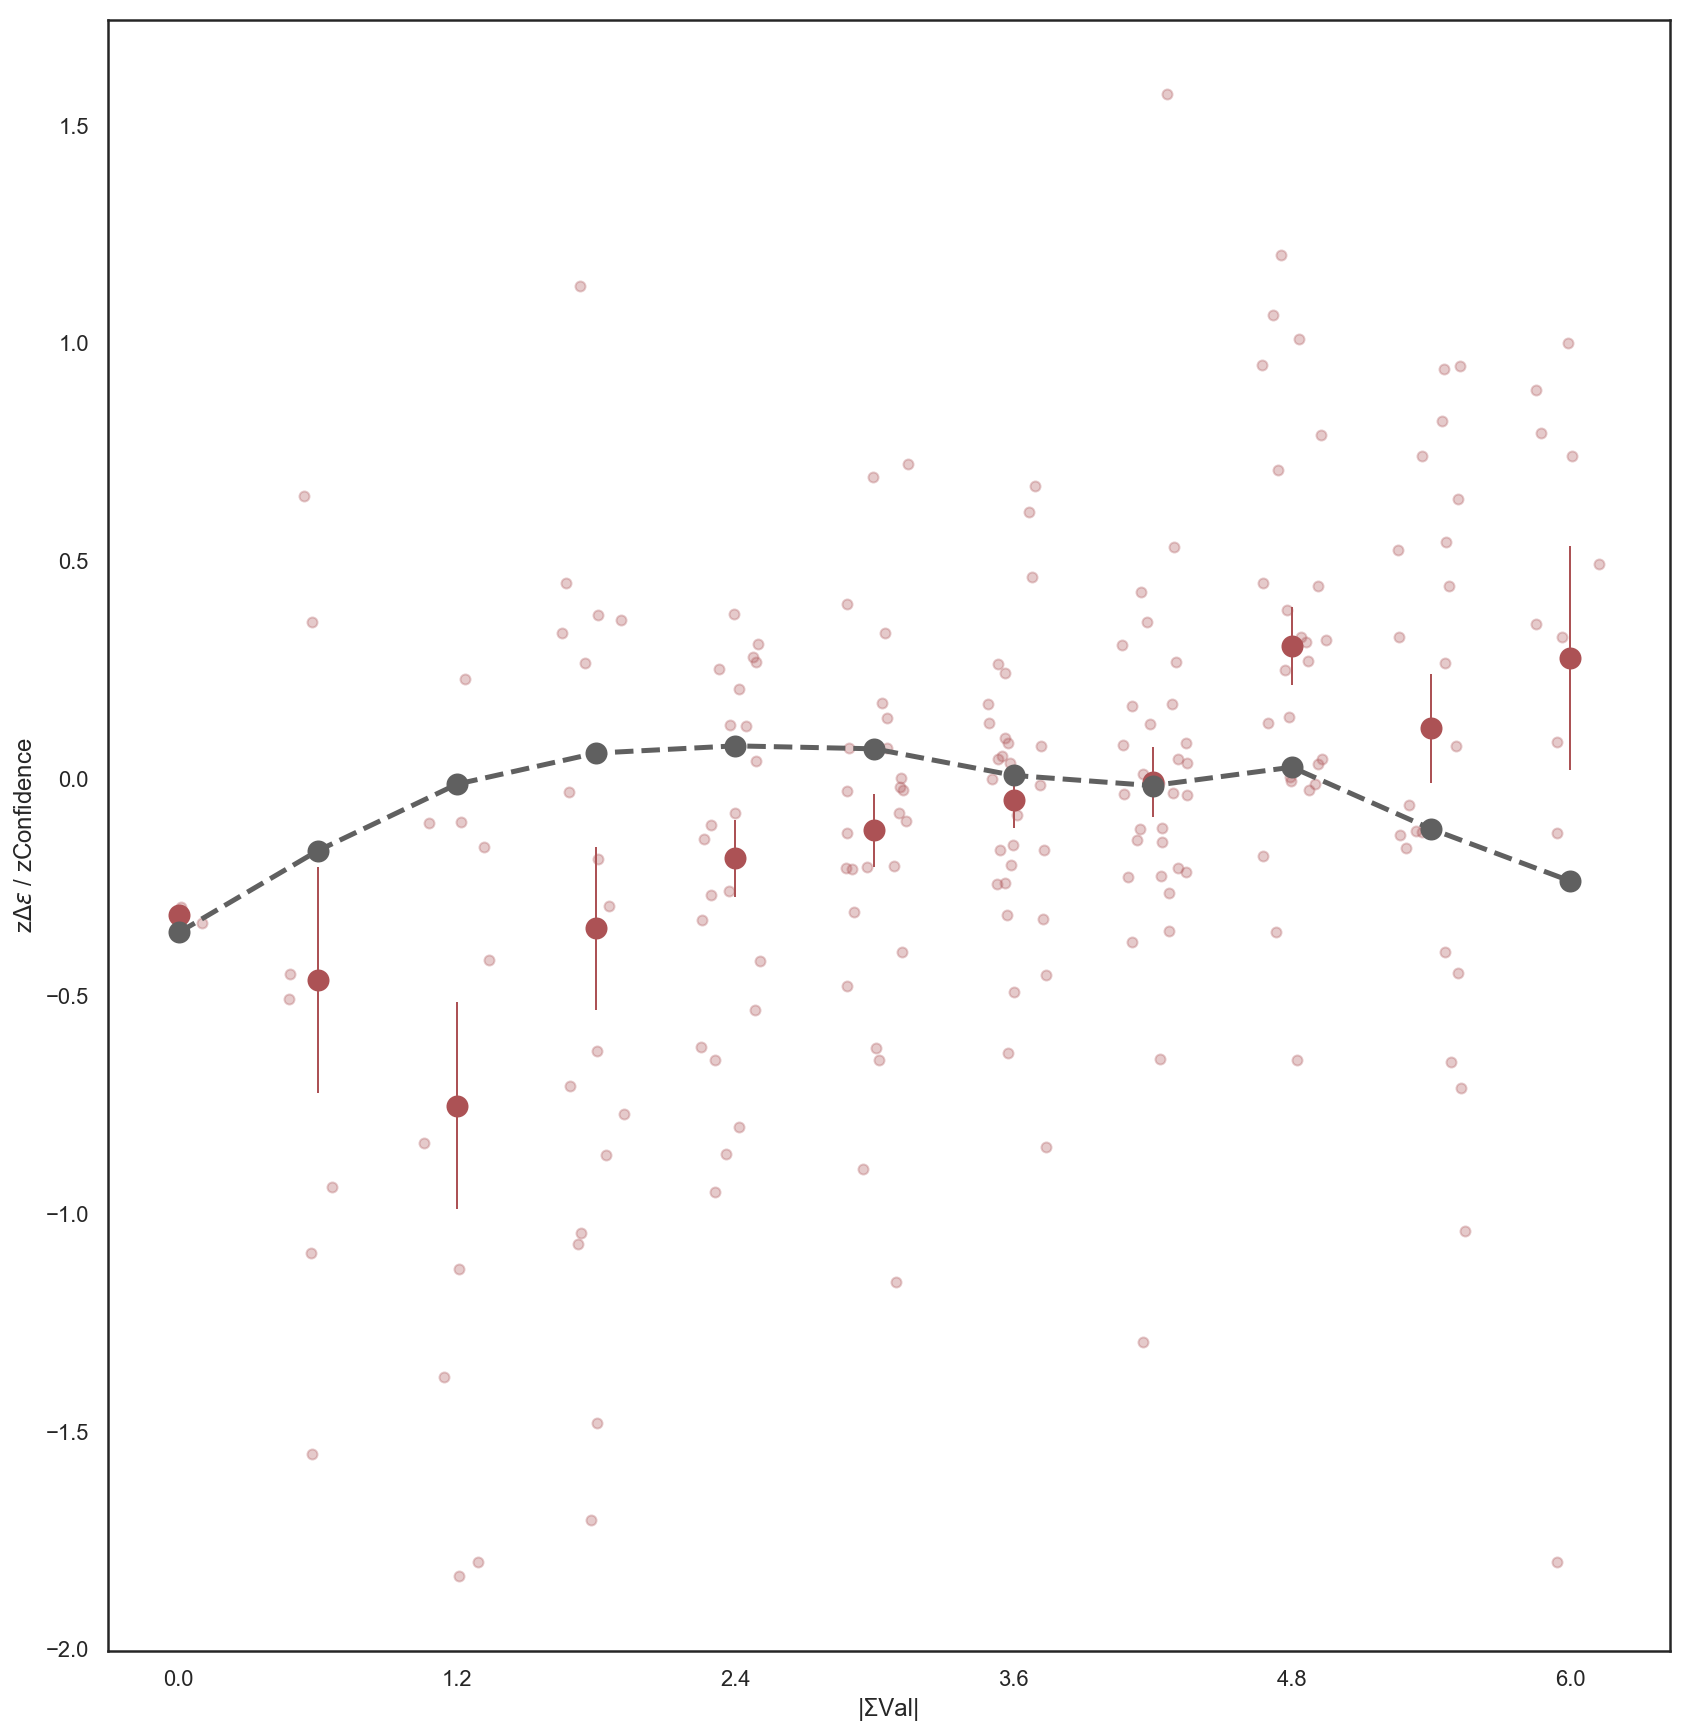

In [120]:
plot_DEv_Conf_TotVal(data_simulation2, xlabel_skip=2,color1 = '#AC5255')